In [1]:
import tensorflow as tf
from tensorflow import keras

# FID Calculation

inc_model = keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(150,150,3))


# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = np.resize(image, new_shape)
        # store
        images_list.append(new_image)
    return np.asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # preprocessing
    images1 = images1.astype('float32')
    images2 = images2.astype('float32')
    # resize images
    images1 = scale_images(images1, (150,150,3))
    images2 = scale_images(images2, (150,150,3))

    images1 = keras.applications.inception_v3.preprocess_input(images1)
    images2 = keras.applications.inception_v3.preprocess_input(images2)
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False, dtype=np.csingle)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False, dtype=np.csingle)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = np.sqrt(sigma1*sigma2)
    # check and correct imaginary numbers from sqrt
    covmean = np.real(covmean)
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return np.real(fid)

# define two fake collections of images
# images1 = np.random.randint(0, 255, 10*32*32*3)
# images1 = images1.reshape((10,32,32,3))
# images2 = np.random.randint(0, 255, 10*32*32*3)
# images2 = images2.reshape((10,32,32,3))

# print(calculate_fid(model, images1, images2))
# print(calculate_fid(model, images1, images1))
# print(calculate_fid(model, images2, images2))

2024-06-21 11:39:34.325124: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 11:39:34.860537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-21 11:39:35.547538: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-21 11:39:35.547757: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

In [2]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
# use sinusoidal position embedding to encode time step (https://arxiv.org/abs/1706.03762)   
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [4]:
# define TimestepEmbedSequential to support `time_emb` as extra input
class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

# use GN for norm layer
def norm_layer(channels):
    return nn.GroupNorm(32, channels)

In [5]:
# Residual block
class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )
        
        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()


    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)

In [6]:
# Attention block with shortcut
class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0
        
        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x

In [7]:
# upsample
class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

# downsample
class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)

In [8]:
# The full UNet model with attention and timestep embedding
class UNetModel(nn.Module):
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        
        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        
        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2
        
        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )
        
        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )
        
    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)

In [9]:
# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1 # 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [10]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas
            
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        #self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )
        
        # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance
    
    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    
    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # predict noise using model
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance
    
    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t,
                                                    clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img
    
    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs
    
    # sample new images
    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3):
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))
    
    # use ddim to sample
    @torch.no_grad()
    def ddim_sample(
        self,
        model,
        image_size,
        batch_size=8,
        channels=3,
        ddim_timesteps=50,
        ddim_discr_method="uniform",
        ddim_eta=0.0,
        clip_denoised=True):
        # make ddim timestep sequence
        if ddim_discr_method == 'uniform':
            c = self.timesteps // ddim_timesteps
            ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
        elif ddim_discr_method == 'quad':
            ddim_timestep_seq = (
                (np.linspace(0, np.sqrt(self.timesteps * .8), ddim_timesteps)) ** 2
            ).astype(int)
        else:
            raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')
        # add one to get the final alpha values right (the ones from first scale to data during sampling)
        ddim_timestep_seq = ddim_timestep_seq + 1
        # previous sequence
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])
        
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
            t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)
            
            # 1. get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod, prev_t, sample_img.shape)
    
            # 2. predict noise using model
            pred_noise = model(sample_img, t)
            
            # 3. get the predicted x_0
            pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
            if clip_denoised:
                pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)
            
            # 4. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            sigmas_t = ddim_eta * torch.sqrt(
                (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))
            
            # 5. compute "direction pointing to x_t" of formula (12)
            pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise
            
            # 6. compute x_{t-1} of formula (12)
            x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

            sample_img = x_prev
            
        return sample_img.cpu().numpy()
    
    # compute train losses
    def train_losses(self, model, x_start, t):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

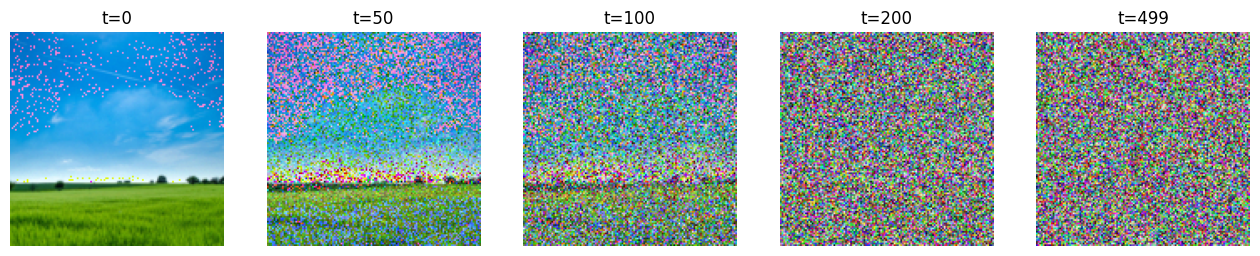

In [11]:
#url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
#image = Image.open(requests.get(url, stream=True).raw)
image = Image.open("sample.png")

image_size = 128
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
#     transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


x_start = transform(image).unsqueeze(0)

gaussian_diffusion = GaussianDiffusion(timesteps=500)

plt.figure(figsize=(16, 8))
for idx, t in enumerate([0, 50, 100, 200, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start, t=torch.tensor([t]))
    noisy_image = (x_noisy.squeeze().permute(1, 2, 0) + 1) * 127.5
    noisy_image = noisy_image.numpy().astype(np.uint8)
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image)
    plt.axis("off")
    plt.title(f"t={t}")

## Base DDPM

### 500 Timesteps (original)

In [12]:
batch_size = 256
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device='cuda:0'


In [14]:
# train
epochs = 5

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        
        if step % 400 == 0:
            tqdm.write(f"Loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.0955941677093506


  0%|          | 1/235 [00:00<00:46,  5.00it/s]

Loss: 0.039165377616882324


  0%|          | 1/235 [00:00<01:01,  3.82it/s]

Loss: 0.023528791964054108


  0%|          | 1/235 [00:00<01:03,  3.70it/s]

Loss: 0.02824041061103344


  0%|          | 1/235 [00:00<01:04,  3.63it/s]

Loss: 0.02582571841776371


100%|██████████| 235/235 [01:30<00:00,  2.61it/s]


sampling loop time step: 100%|██████████| 500/500 [00:16<00:00, 31.23it/s]


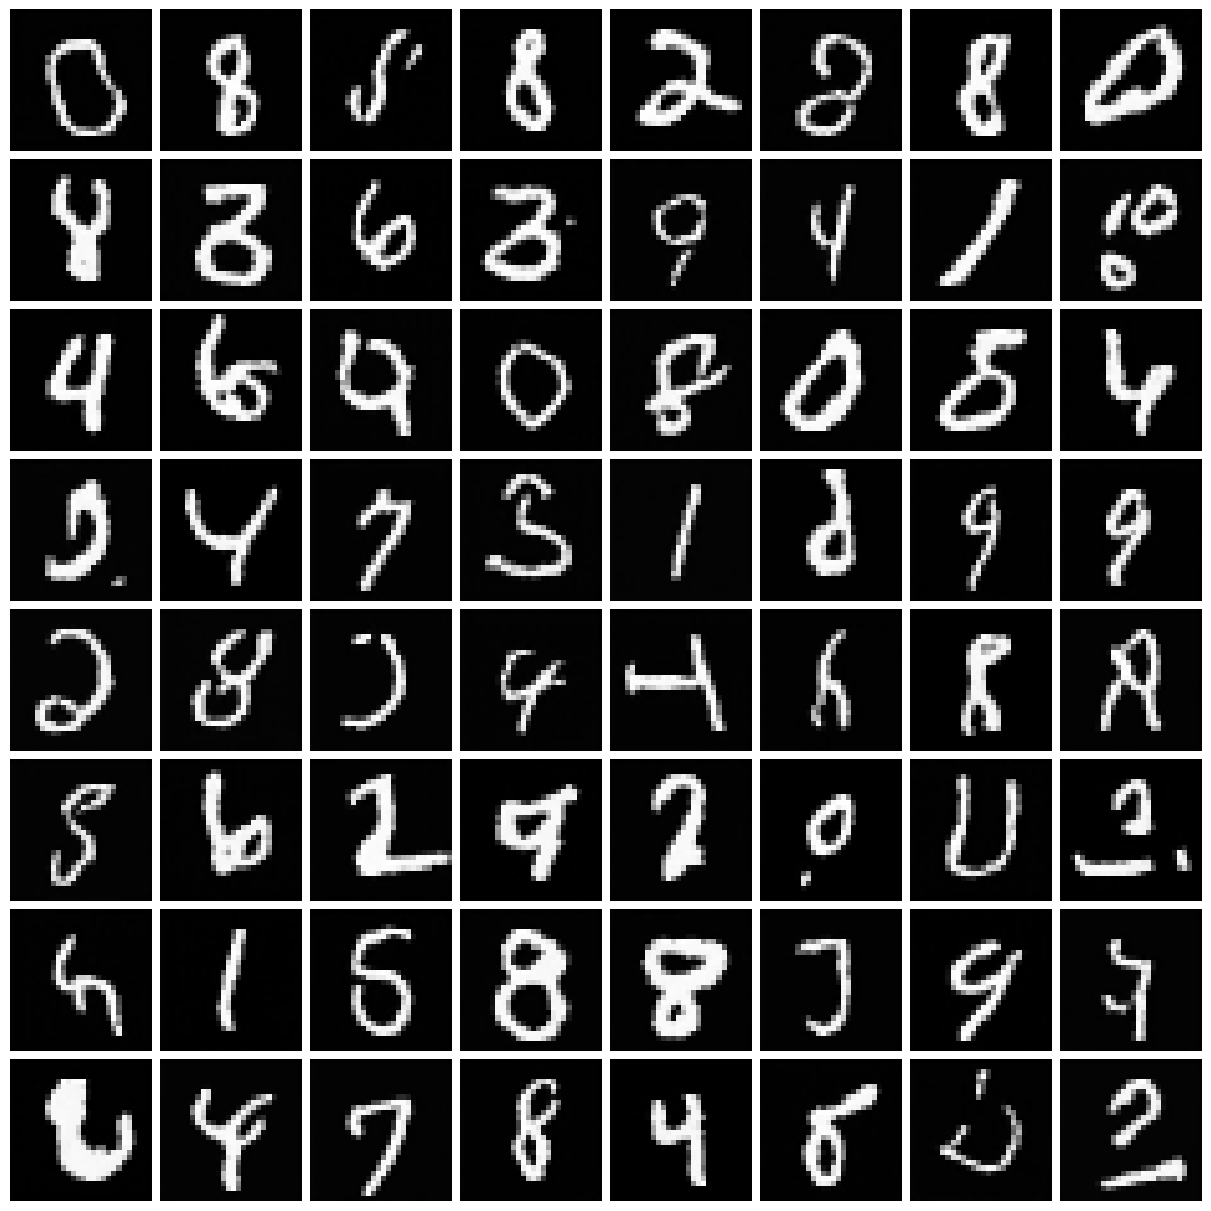

In [15]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1)

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [22]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
imgs = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)
images_from_ddpm = (255*(1 + imgs[-1].copy())/2) 
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_ddpm, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

sampling loop time step: 100%|██████████| 500/500 [04:36<00:00,  1.81it/s]


 1/32 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step

2024-05-29 16:57:04.789480: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 270000000 exceeds 10% of free system memory.


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step
 1/32 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step

2024-05-29 16:57:11.536234: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 270000000 exceeds 10% of free system memory.


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step
FID (1000 images) : 10.86165714263916


In [19]:
# saving the model
torch.save(model, 'models/DDPM_base.pt')

In [14]:
# loading the model
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)

model = torch.load('models/DDPM_base.pt')
sum([p.numel() for p in model.parameters()])

13796545

### 2 Timesteps

In [16]:
batch_size = 256
timesteps = 2

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device='cuda:1'


In [17]:
# train
epochs = 5

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        
        if step % 400 == 0:
            tqdm.write(f"Loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.0804086923599243


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.17063701152801514


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.16221481561660767


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.13793572783470154


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.1355009377002716


sampling loop time step:   0%|          | 0/2 [00:00<?, ?it/s]

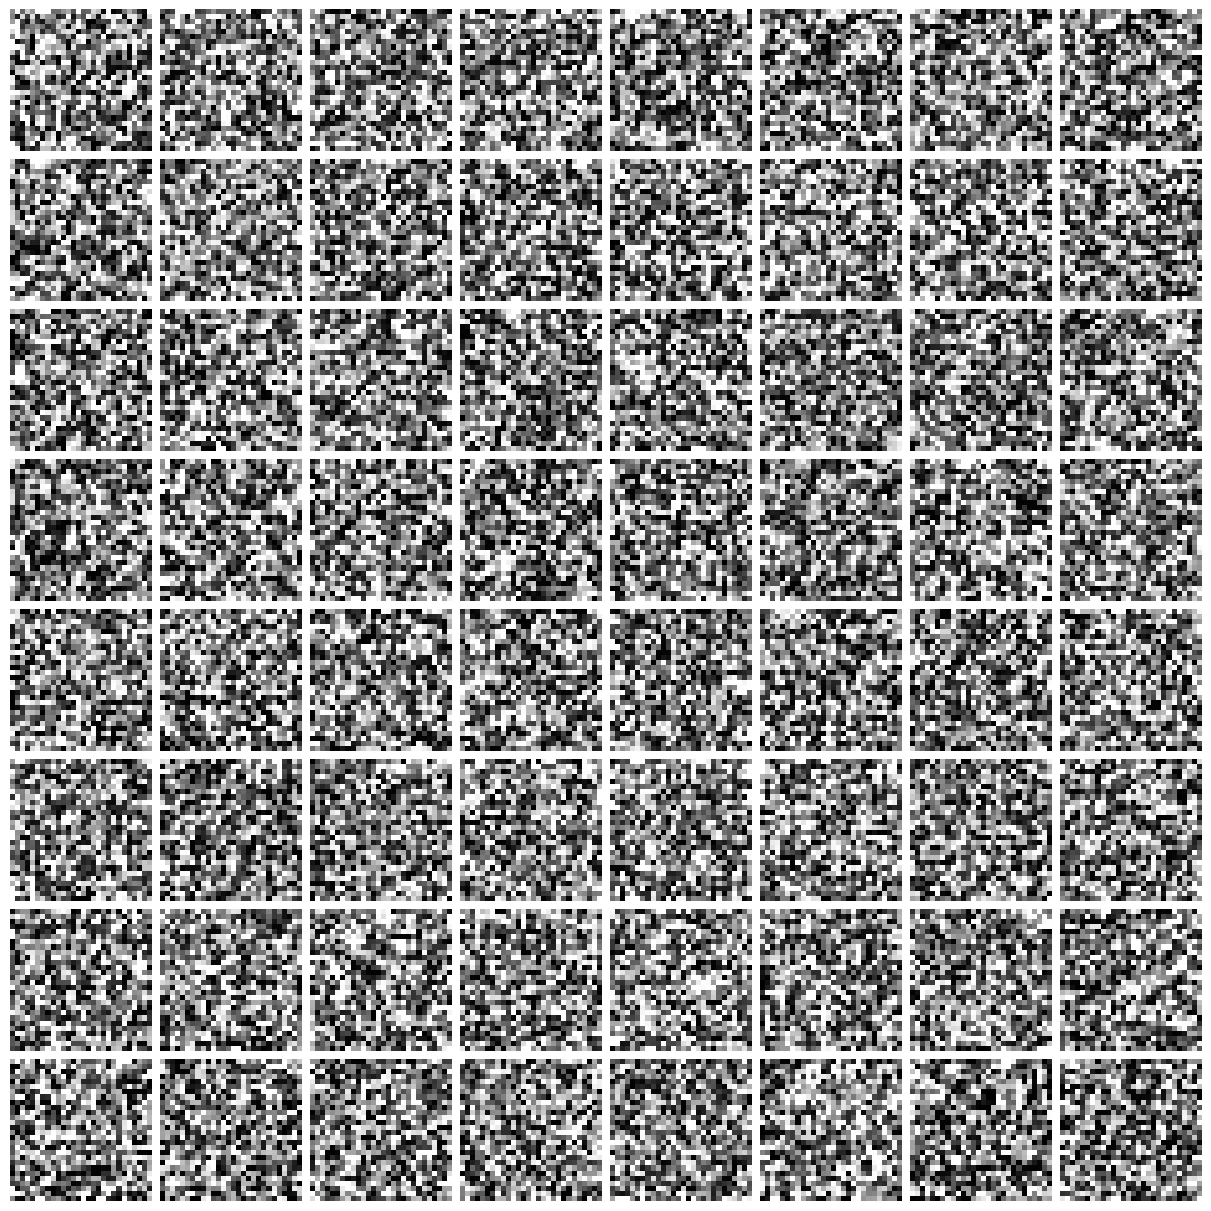

In [18]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1)

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

### 5 Timesteps

In [19]:
batch_size = 256
timesteps = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device='cuda:1'


In [20]:
# train
epochs = 5

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        
        if step % 400 == 0:
            tqdm.write(f"Loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.1041663885116577


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.13703198730945587


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.12930256128311157


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.12027187645435333


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.11142058670520782


sampling loop time step:   0%|          | 0/5 [00:00<?, ?it/s]

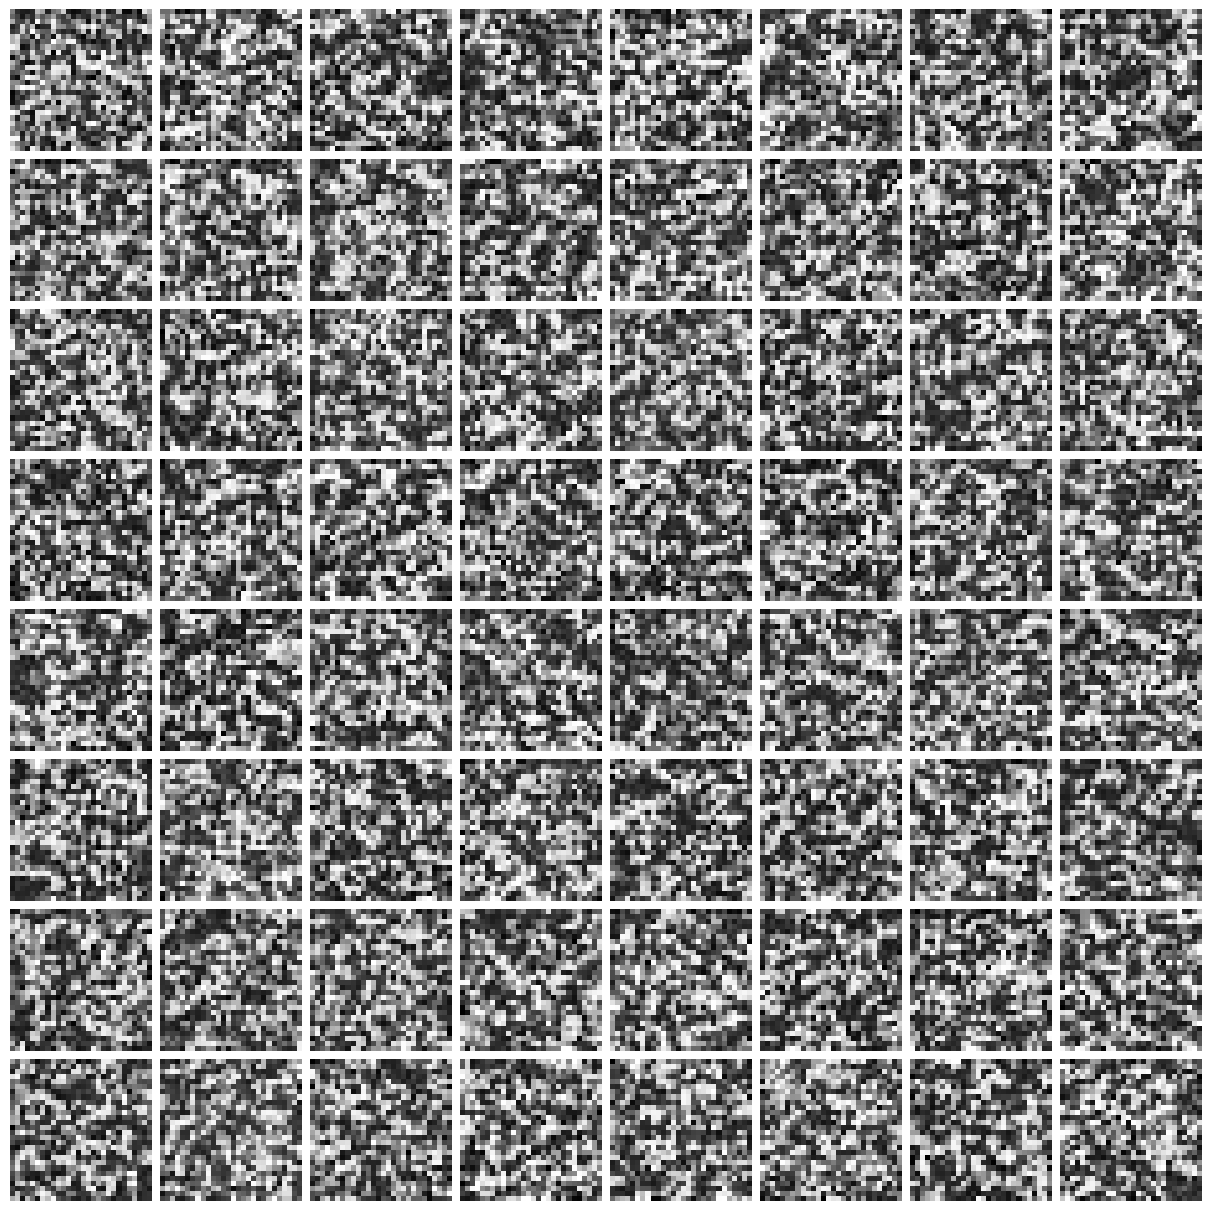

In [21]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1)

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

### 10 Timesteps

In [22]:
batch_size = 256
timesteps = 10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device='cuda:1'


In [23]:
# train
epochs = 5

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        
        if step % 400 == 0:
            tqdm.write(f"Loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.4206899404525757


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.12500524520874023


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.11018464714288712


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.09894925355911255


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.09449391067028046


sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

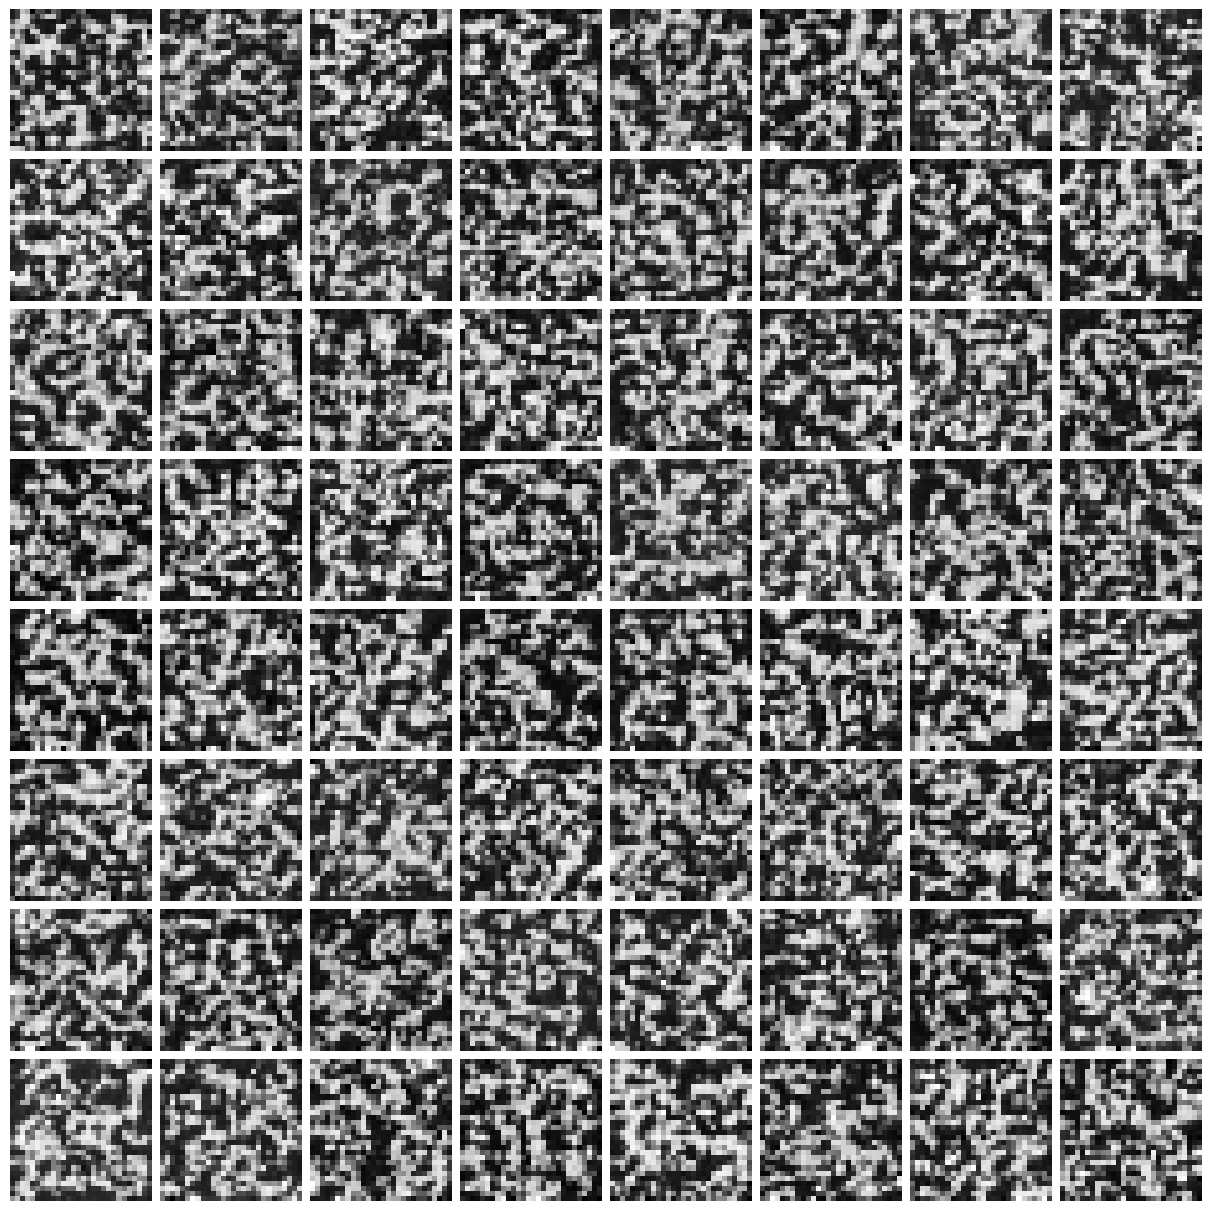

In [24]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1)

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

### 50 Timesteps

In [12]:
batch_size = 256
timesteps = 50

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device='cuda:1'


In [13]:
# train
epochs = 5

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        
        if step % 400 == 0:
            tqdm.write(f"Loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.1437782049179077


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.08627410978078842


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.07929933071136475


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.06981497257947922


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.06997562199831009


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

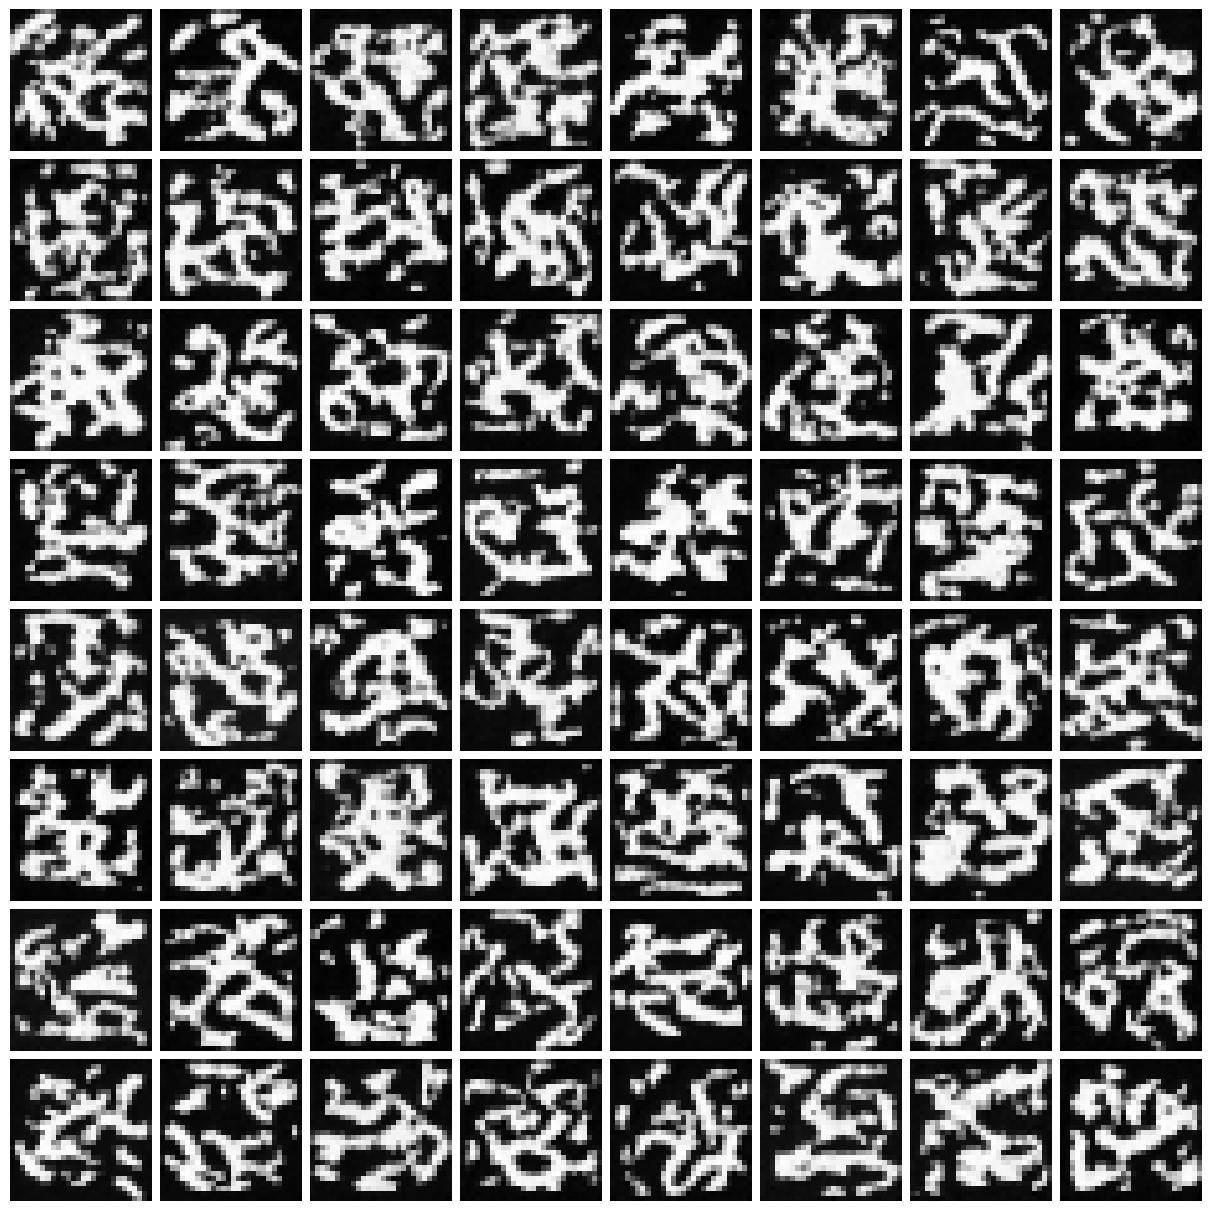

In [14]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1)

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

### 100 Timesteps

In [15]:
batch_size = 256
timesteps = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device='cuda:1'


In [16]:
# train
epochs = 5

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        
        if step % 400 == 0:
            tqdm.write(f"Loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.161228060722351


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.08043168485164642


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.06890083849430084


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.06010091304779053


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.062051158398389816


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

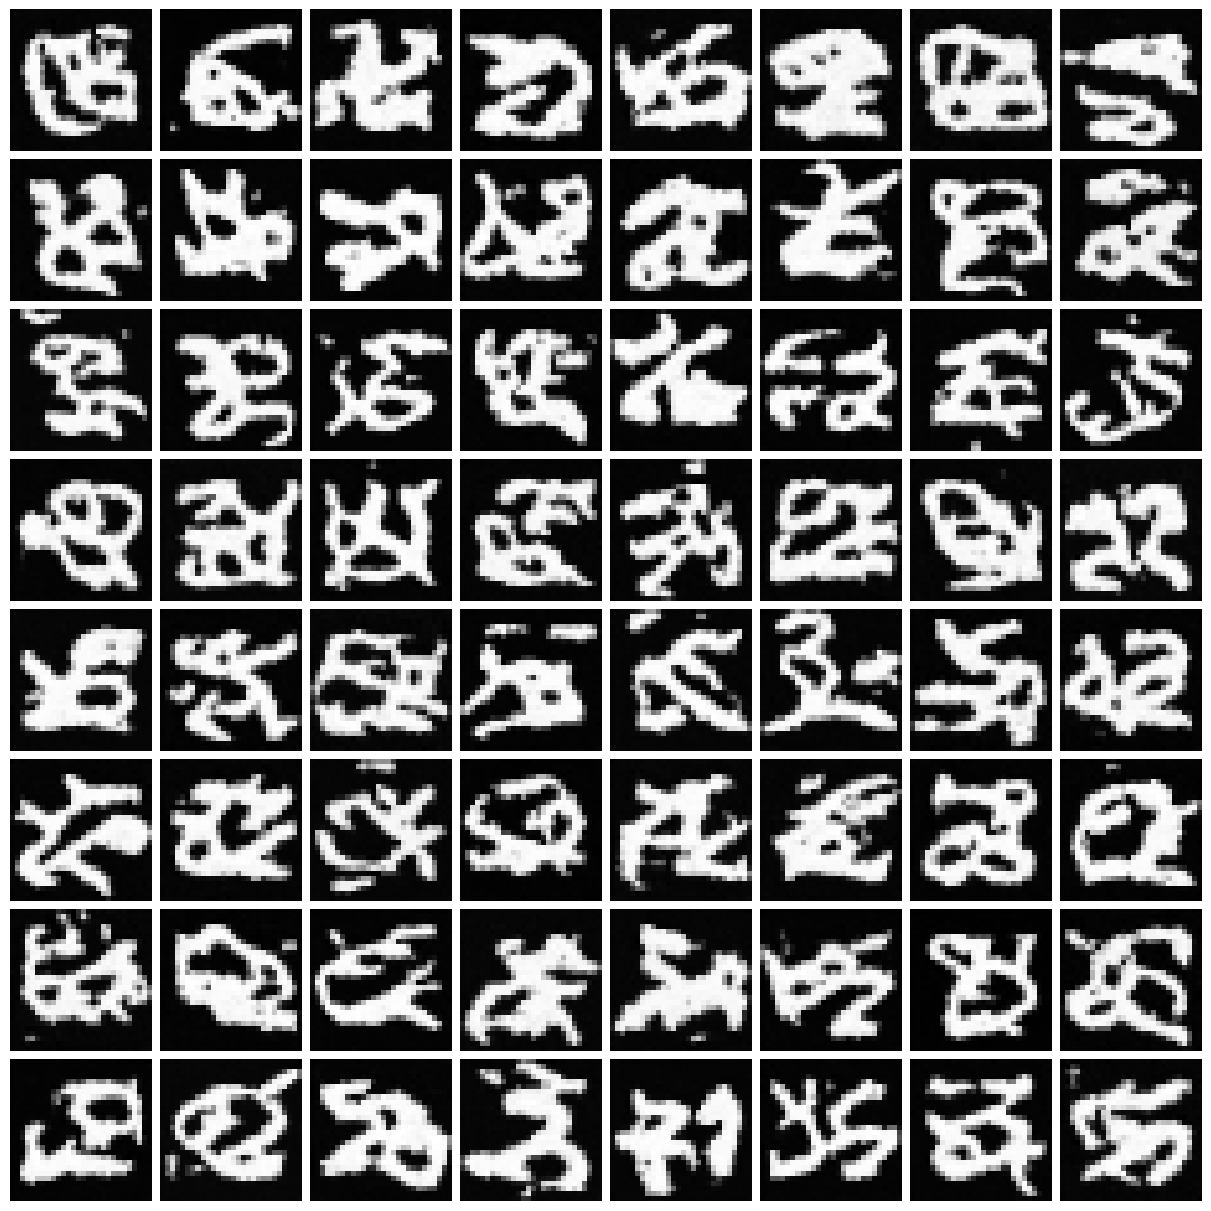

In [17]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1)

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

### 200 Timesteps

In [21]:
batch_size = 256
timesteps = 200

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device='cuda:1'


In [22]:
# train
epochs = 5

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        
        if step % 400 == 0:
            tqdm.write(f"Loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.231382966041565


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.05581176280975342


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.05216865614056587


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.04742075875401497


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.04686972126364708


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

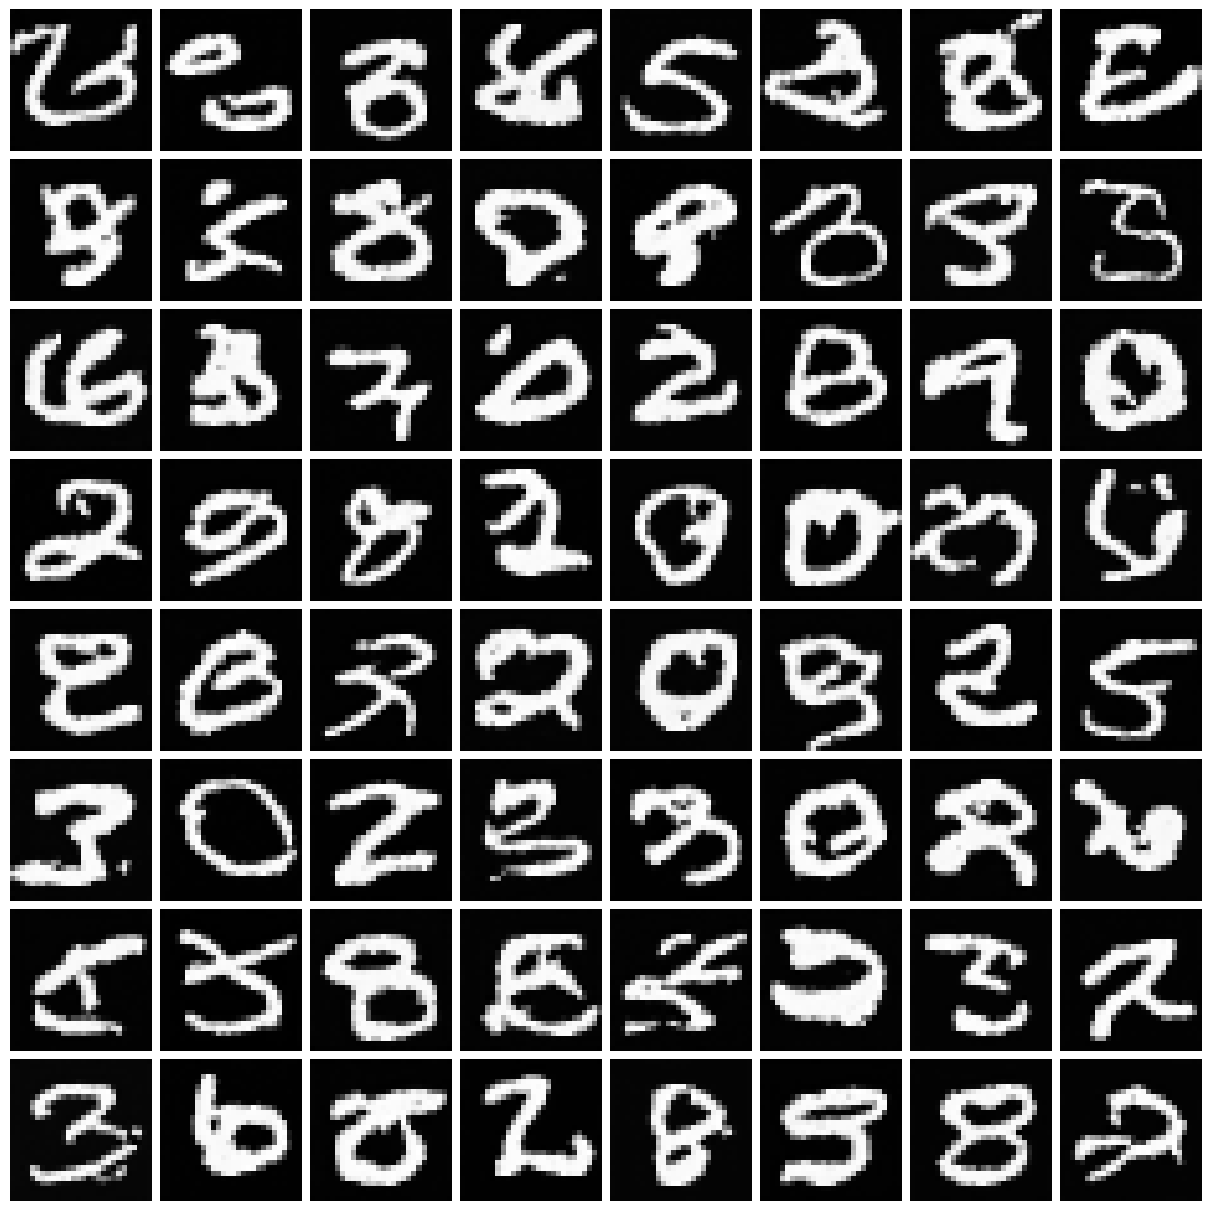

In [23]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1)

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [24]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
imgs = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)
images_from_ddpm = (255*(1 + imgs[-1].copy())/2) 
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_ddpm, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step
FID (1000 images) : 104.04306030273438


### 300 Timesteps

In [25]:
batch_size = 256
timesteps = 300

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device='cuda:1'


In [26]:
# train
epochs = 5

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        
        if step % 400 == 0:
            tqdm.write(f"Loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.0493725538253784


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.05311735346913338


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.04562968388199806


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.04505440592765808


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.044311538338661194


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

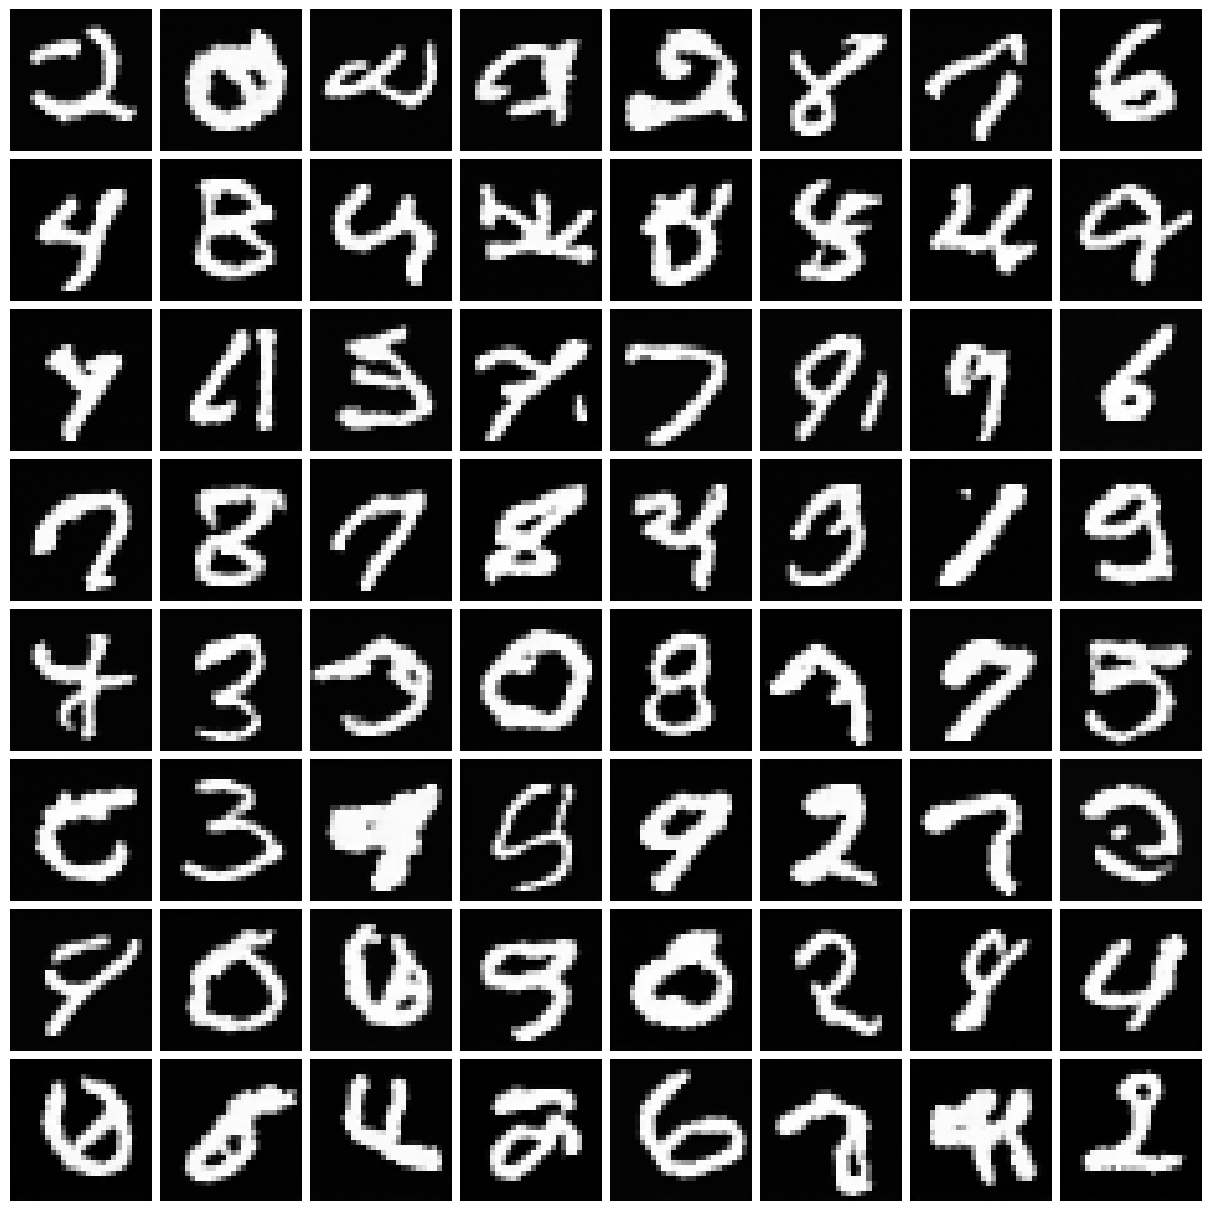

In [27]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1)

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [28]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
imgs = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)
images_from_ddpm = (255*(1 + imgs[-1].copy())/2) 
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_ddpm, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step
FID (1000 images) : 30.361392974853516


### 400 Timesteps

In [29]:
batch_size = 256
timesteps = 400

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device='cuda:1'


In [30]:
# train
epochs = 5

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        
        if step % 400 == 0:
            tqdm.write(f"Loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.1401727199554443


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.04571793973445892


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.0433773510158062


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.03823431581258774


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.03861182555556297


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

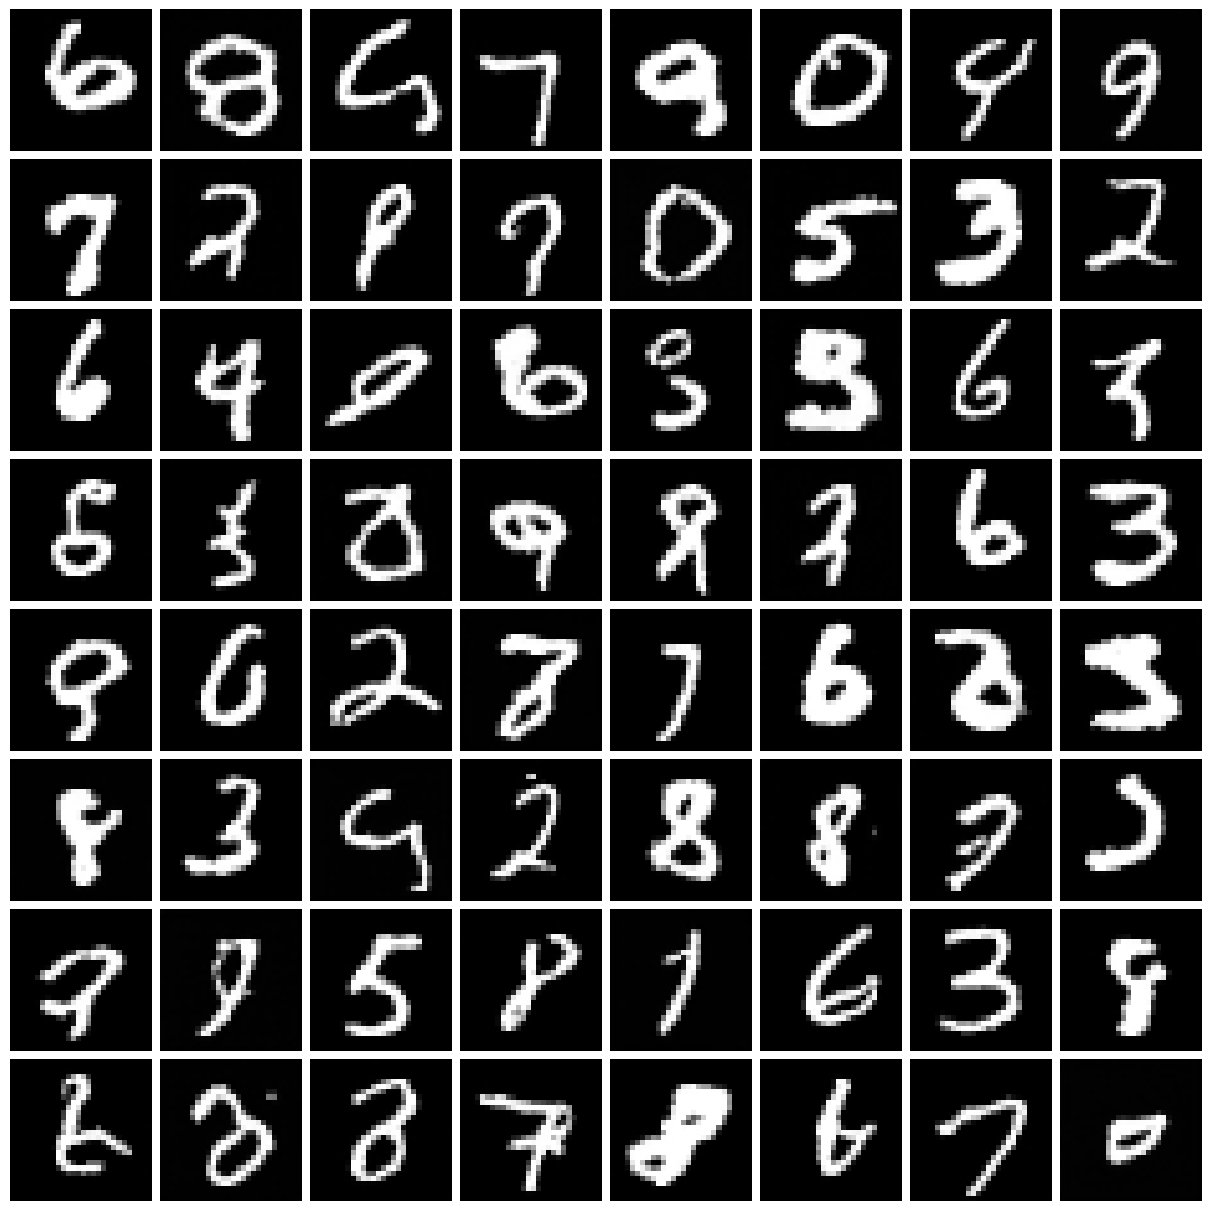

In [31]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1)

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [32]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
imgs = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)
images_from_ddpm = (255*(1 + imgs[-1].copy())/2) 
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_ddpm, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step
FID (1000 images) : 12.352972984313965


### 500 Timesteps

In [33]:
batch_size = 256
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device='cuda:1'


In [34]:
# train
epochs = 5

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        
        if step % 400 == 0:
            tqdm.write(f"Loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.007596731185913


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.04474547505378723


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.0384763665497303


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.03347920998930931


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.034304480999708176


sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

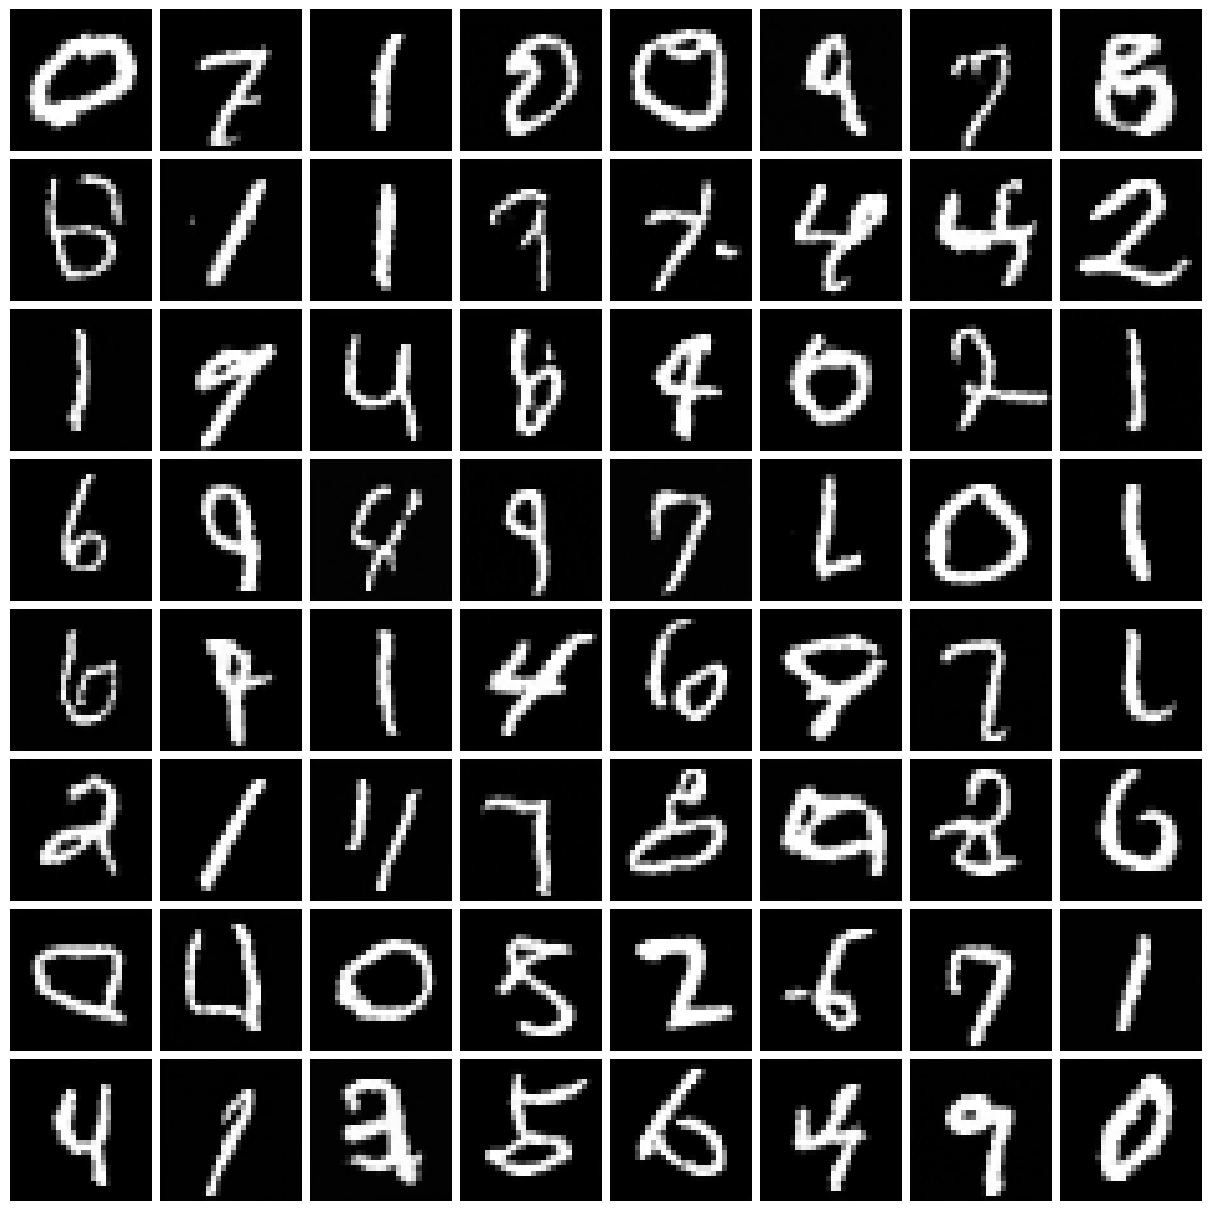

In [35]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1)

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [37]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
imgs = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)
images_from_ddpm = (255*(1 + imgs[-1].copy())/2) 
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_ddpm, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step
FID (1000 images) : 11.635014533996582


### FID plot

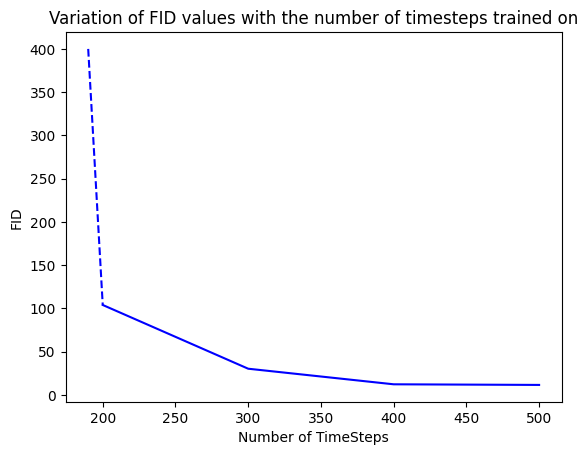

In [47]:
times = [200,300,400,500]
fids = [104.04, 30.36, 12.35, 11.63]
times_dashed = [190,200]
fids_dashed = [400, 104.04]
plt.plot(times, fids, c='blue')
plt.plot(times_dashed, fids_dashed, c='blue', linestyle='--')
plt.ylabel('FID')
plt.xlabel('Number of TimeSteps')
plt.title('Variation of FID values with the number of timesteps trained on');

## Improved DDPM : with linear beta schedule

In [15]:
# Residual block
class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout, use_scale_shift_norm=False):
        super().__init__()
        self.use_scale_shift_norm = use_scale_shift_norm
        
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, 2 * out_channels if use_scale_shift_norm else out_channels)
        )
        
        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()
    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        emb_out = self.time_emb(t)[:, :, None, None]
        if self.use_scale_shift_norm:
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = self.conv2[0](h) * (1 + scale) + shift # GroupNorm(h)(w+1) + b
            h = self.conv2[1:](h)
        else:
            h = self.conv2(h + emb_out)
        return h + self.shortcut(x)

In [16]:
# The full UNet model with attention and timestep embedding
class UNetModel(nn.Module):
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4,
        use_scale_shift_norm=True,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        
        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        
        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout,
                        use_scale_shift_norm=use_scale_shift_norm)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2
        
        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm)
        )
        
        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout,
                        use_scale_shift_norm=use_scale_shift_norm
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )
    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        
        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)

In [32]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas
            
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        #self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )
    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance
    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # predict noise and variance_vector using model
        model_output = model(x_t, t)
        pred_noise, pred_variance_v = torch.chunk(model_output, 2, dim=1)
        
        # compute predicted variance by eq(15) in the paper
        min_log_variance = self._extract(self.posterior_log_variance_clipped, t, x_t.shape) # beta_t~
        max_log_variance = self._extract(torch.log(self.betas), t, x_t.shape) # beta_t
        # The predict value is in [-1, 1], we should convert it to [0, 1]
        frac = (pred_variance_v + 1.) / 2.
        model_log_variance = frac * max_log_variance + (1. - frac) * min_log_variance
        model_variance = torch.exp(model_log_variance)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, _, _ = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, model_variance, model_log_variance
        
    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t,
                                                    clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img
    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs
    
    # sample new images
    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3):
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))
    
    # use ddim to sample
    @torch.no_grad()
    def ddim_sample(
        self,
        model,
        image_size,
        batch_size=8,
        channels=3,
        ddim_timesteps=50,
        ddim_discr_method="uniform",
        ddim_eta=0.0,
        clip_denoised=True):
        # make ddim timestep sequence
        if ddim_discr_method == 'uniform':
            c = self.timesteps // ddim_timesteps
            ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
        elif ddim_discr_method == 'quad':
            ddim_timestep_seq = (
                (np.linspace(0, np.sqrt(self.timesteps * .8), ddim_timesteps)) ** 2
            ).astype(int)
        else:
            raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')
        # add one to get the final alpha values right (the ones from first scale to data during sampling)
        ddim_timestep_seq = ddim_timestep_seq + 1
        # previous sequence
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])
        
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
            t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)

            # 1. get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod, prev_t, sample_img.shape)
    
            # 2. predict using model
            model_output = model(sample_img, t)
            pred_noise, _ = torch.chunk(model_output, 2, dim=1)
            
            # 3. get the predicted x_0
            pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
            if clip_denoised:
                pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)
            
            # 4. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            sigmas_t = ddim_eta * torch.sqrt(
                (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))
            
            # 5. compute "direction pointing to x_t" of formula (12)
            pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise
            
            # 6. compute x_{t-1} of formula (12)
            x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

            sample_img = x_prev
            
        return sample_img.cpu().numpy()
    # use fast sample of DDPM+
    @torch.no_grad()
    def fast_sample(
        self,
        model,
        image_size,
        batch_size=8,
        channels=3,
        timestep_respacing="50",
        clip_denoised=True):
        # make timestep sequence
        # https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/respace.py
        section_counts = [int(x) for x in timestep_respacing.split(",")]
        size_per = self.timesteps // len(section_counts)
        extra = self.timesteps % len(section_counts)
        start_idx = 0
        timestep_seq = []
        for i, section_count in enumerate(section_counts):
            size = size_per + (1 if i < extra else 0)
            if size < section_count:
                raise ValueError(
                f"cannot divide section of {size} steps into {section_count}"
                )
            if section_count <= 1:
                frac_stride = 1
            else:
                frac_stride = (size - 1) / (section_count - 1)
            cur_idx = 0.0
            taken_steps = []
            for _ in range(section_count):
                taken_steps.append(start_idx + round(cur_idx))
                cur_idx += frac_stride
            timestep_seq += taken_steps
            start_idx += size
        total_timesteps = len(timestep_seq)
        # previous sequence
        timestep_prev_seq = np.append(np.array([-1]), timestep_seq[:-1])
        
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        for i in tqdm(reversed(range(0, total_timesteps)), desc='sampling loop time step', total=total_timesteps):
            t = torch.full((batch_size,), timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), timestep_prev_seq[i], device=device, dtype=torch.long)
            
            # get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod_prev, prev_t + 1, sample_img.shape)
    
            # predict noise using model
            model_output = model(sample_img, t)
            pred_noise, pred_variance_v = torch.chunk(model_output, 2, dim=1)
            # compute beta_t and beta_t~ by eq(19) in the paper
            new_beta_t =  1. - alpha_cumprod_t / alpha_cumprod_t_prev
            new_beta_t2 = new_beta_t * (1. - alpha_cumprod_t_prev) / (1. - alpha_cumprod_t)
            min_log_variance = torch.log(new_beta_t2) #  beta_t~
            max_log_variance =  torch.log(new_beta_t) # beta_t
            # compute predicted variance by eq(15) in the paper
            # The predict value is in [-1, 1], we should convert it to [0, 1]
            frac = (pred_variance_v + 1.) / 2.
            model_log_variance = frac * max_log_variance + (1. - frac) * min_log_variance
            
            # get the predicted x_0: different from the algorithm2 in the paper
            x_recon = self.predict_start_from_noise(sample_img, t, pred_noise)
            if clip_denoised:
                x_recon = torch.clamp(x_recon, min=-1., max=1.)
            mean_coef1 = (new_beta_t * torch.sqrt(alpha_cumprod_t_prev) / (1.0 - alpha_cumprod_t))
            mean_coef2 = ((1.0 - alpha_cumprod_t_prev) * torch.sqrt(1.0 - new_beta_t)/ (1.0 - alpha_cumprod_t))
            model_mean = mean_coef1 * x_recon + mean_coef2 * sample_img
            
            noise = torch.randn_like(sample_img)
            # no noise when t == 0
            nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(sample_img.shape) - 1))))
            # compute x_{t-1}
            x_prev = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

            sample_img = x_prev
            
        return sample_img.cpu().numpy()
    def train_losses(self, model, x_start, t):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        
        # predict
        model_output = model(x_noisy, t)
        pred_noise, pred_variance_v = torch.chunk(model_output, 2, dim=1)
        
        # compute VLB loss
        # only learn variance, but use frozen predicted noise
        frozen_output = torch.cat([pred_noise.detach(), pred_variance_v], dim=1)
        # ground truth
        true_mean, _, true_log_variance_clipped = self.q_posterior_mean_variance(x_start, x_noisy, t)
        # prediction
        model_mean, _, model_log_variance = self.p_mean_variance(
            lambda *args, r=frozen_output: r, # use a simple lambda
            x_noisy,
            t,
            clip_denoised=False
        )
        # for t > 0, compute KL
        kl = normal_kl(true_mean, true_log_variance_clipped, model_mean, model_log_variance)
        kl = torch.mean(kl, dim=[1, 2, 3]) / np.log(2.0) # use 2 for log base
        # for t = 0, compute NLL
        decoder_nll = -discretized_gaussian_log_likelihood(x_start, model_mean, 0.5 * model_log_variance)
        decoder_nll = torch.mean(decoder_nll, dim=[1, 2, 3]) / np.log(2.0)
        vlb_loss = torch.where((t == 0), decoder_nll, kl)
        # reweight VLB
        vlb_loss *= self.timesteps / 1000
        
        # compute MSE loss
        mse_loss = torch.mean((pred_noise - noise) ** 2, dim=[1, 2, 3])
        
        loss = (mse_loss + vlb_loss).mean()
        return loss

In [18]:
# some helpful functions to compute loss
def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    KL divergence between normal distributions parameterized by mean and log-variance.
    """
    return 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + \
                  ((mean1 - mean2) ** 2) * torch.exp(-logvar2))


def approx_standard_normal_cdf(x):
    """
    A fast approximation of the cumulative distribution function of the
    standard normal.
    """
    return 0.5 * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * (x ** 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    """
    Compute the log-likelihood of a Gaussian distribution discretizing to a
    given image, using the eq(13) of the paper DDPM.
    """
    assert x.shape == means.shape == log_scales.shape

    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(cdf_plus.clamp(min=1e-12))
    log_one_minus_cdf_min = torch.log((1.0 - cdf_min).clamp(min=1e-12))
    cdf_delta = cdf_plus - cdf_min

    log_probs = torch.where(x < -0.999, log_cdf_plus,
        torch.where(x > 0.999,
            log_one_minus_cdf_min,
            torch.log(cdf_delta.clamp(min=1e-12))))

    return log_probs

In [16]:
batch_size = 128
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=2,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
    use_scale_shift_norm=False,
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps, beta_schedule='linear')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device='cuda'


In [17]:
# train
epochs = 5

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        
        if step % 400 == 0:
            tqdm.write(f"Loss: {loss.item()}")
        
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 1.1968493461608887


 86%|████████▌ | 401/469 [01:13<00:12,  5.29it/s]

Loss: 0.03559684753417969


  0%|          | 1/469 [00:00<01:14,  6.29it/s]

Loss: 0.04371220991015434


 86%|████████▌ | 401/469 [01:16<00:13,  5.20it/s]

Loss: 0.026461968198418617


  0%|          | 1/469 [00:00<01:19,  5.90it/s]

Loss: 0.03174272179603577


 86%|████████▌ | 401/469 [01:17<00:13,  5.10it/s]

Loss: 0.026282239705324173


  0%|          | 1/469 [00:00<01:21,  5.72it/s]

Loss: 0.02786392904818058


 86%|████████▌ | 401/469 [01:18<00:13,  5.07it/s]

Loss: 0.02916824445128441


  0%|          | 1/469 [00:00<01:23,  5.64it/s]

Loss: 0.022201672196388245


 86%|████████▌ | 401/469 [01:18<00:13,  5.02it/s]

Loss: 0.025150753557682037


100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


sampling loop time step: 100%|██████████| 500/500 [00:14<00:00, 35.02it/s]


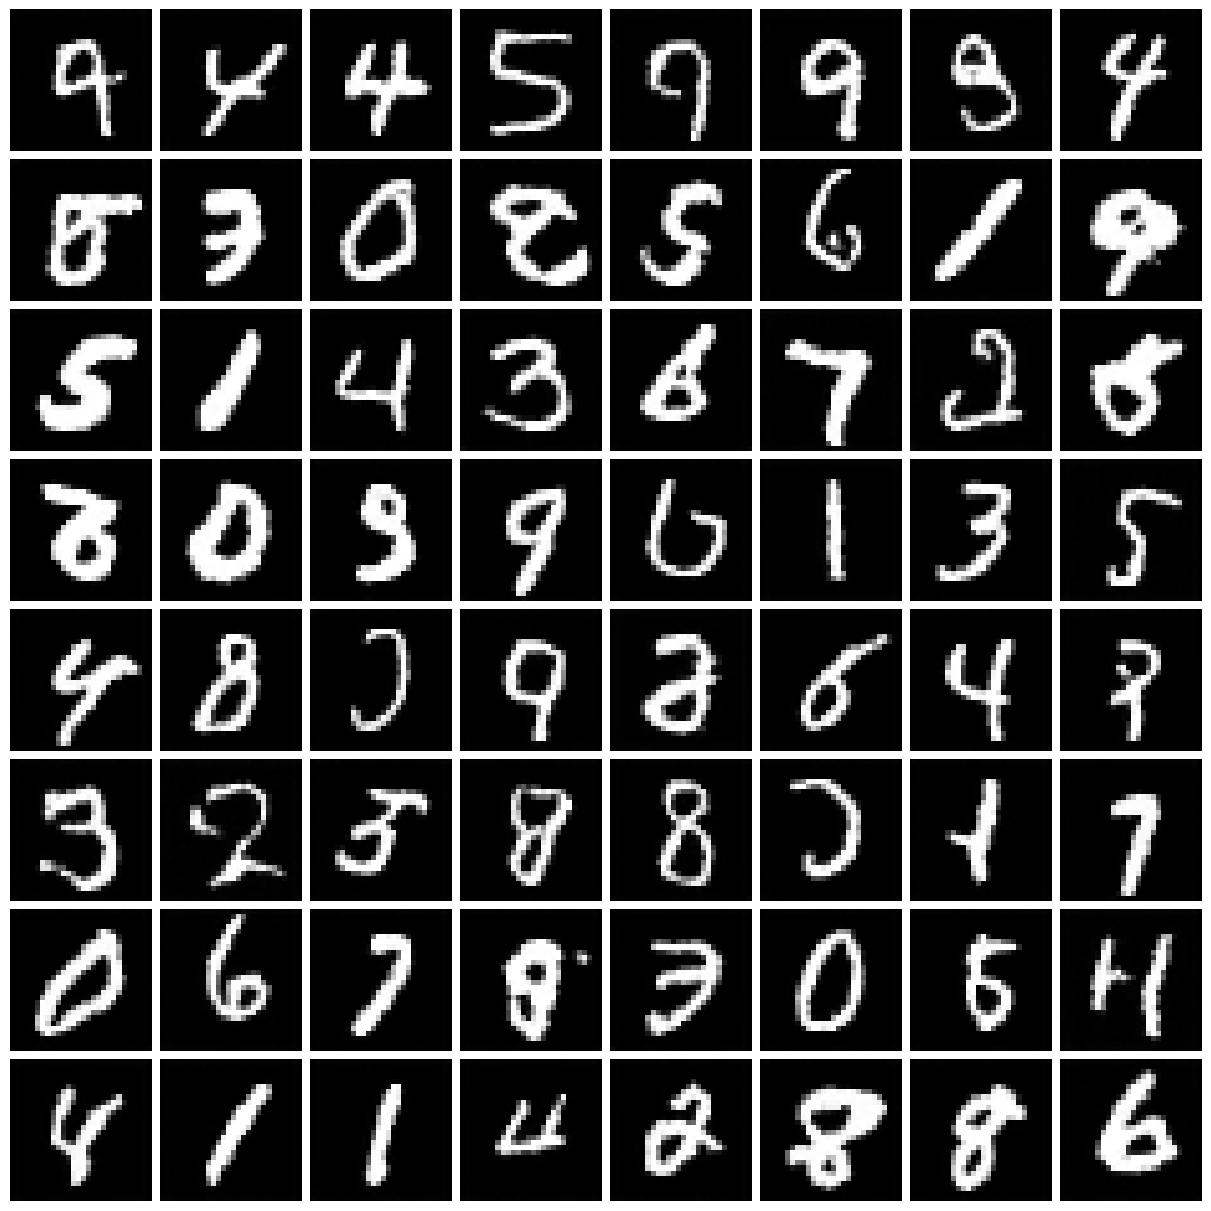

In [18]:
# generate new images
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1)

fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [19]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
imgs = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)
images_from_ddpm = (255*(1 + imgs[-1].copy())/2) 
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_ddpm, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

sampling loop time step: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step
FID (1000 images) : 7.722492218017578


In [20]:
torch.save(model, 'models/DDPM_improved_linear.pt')

In [19]:
# loading the model
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=2,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
    use_scale_shift_norm=False,
)
model = torch.load('models/DDPM_improved_linear.pt')
sum([p.numel() for p in model.parameters()])

13797410

### Improved DDPM, cosine beta schedule

In [12]:
# Residual block
class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout, use_scale_shift_norm=False):
        super().__init__()
        self.use_scale_shift_norm = use_scale_shift_norm
        
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, 2 * out_channels if use_scale_shift_norm else out_channels)
        )
        
        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()
    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        emb_out = self.time_emb(t)[:, :, None, None]
        if self.use_scale_shift_norm:
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = self.conv2[0](h) * (1 + scale) + shift # GroupNorm(h)(w+1) + b
            h = self.conv2[1:](h)
        else:
            h = self.conv2(h + emb_out)
        return h + self.shortcut(x)

In [13]:
# The full UNet model with attention and timestep embedding
class UNetModel(nn.Module):
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4,
        use_scale_shift_norm=True,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        
        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        
        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout,
                        use_scale_shift_norm=use_scale_shift_norm)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2
        
        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm)
        )
        
        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout,
                        use_scale_shift_norm=use_scale_shift_norm
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )
    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        
        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)

In [14]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas
            
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        #self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )
    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance
    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # predict noise and variance_vector using model
        model_output = model(x_t, t)
        pred_noise, pred_variance_v = torch.chunk(model_output, 2, dim=1)
        
        # compute predicted variance by eq(15) in the paper
        min_log_variance = self._extract(self.posterior_log_variance_clipped, t, x_t.shape) # beta_t~
        max_log_variance = self._extract(torch.log(self.betas), t, x_t.shape) # beta_t
        # The predict value is in [-1, 1], we should convert it to [0, 1]
        frac = (pred_variance_v + 1.) / 2.
        model_log_variance = frac * max_log_variance + (1. - frac) * min_log_variance
        model_variance = torch.exp(model_log_variance)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, _, _ = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, model_variance, model_log_variance
        
    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t,
                                                    clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img
    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs
    
    # sample new images
    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3):
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))
    
    # use ddim to sample
    @torch.no_grad()
    def ddim_sample(
        self,
        model,
        image_size,
        batch_size=8,
        channels=3,
        ddim_timesteps=50,
        ddim_discr_method="uniform",
        ddim_eta=0.0,
        clip_denoised=True):
        # make ddim timestep sequence
        if ddim_discr_method == 'uniform':
            c = self.timesteps // ddim_timesteps
            ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
        elif ddim_discr_method == 'quad':
            ddim_timestep_seq = (
                (np.linspace(0, np.sqrt(self.timesteps * .8), ddim_timesteps)) ** 2
            ).astype(int)
        else:
            raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')
        # add one to get the final alpha values right (the ones from first scale to data during sampling)
        ddim_timestep_seq = ddim_timestep_seq + 1
        # previous sequence
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])
        
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
            t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)

            # 1. get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod, prev_t, sample_img.shape)
    
            # 2. predict using model
            model_output = model(sample_img, t)
            pred_noise, _ = torch.chunk(model_output, 2, dim=1)
            
            # 3. get the predicted x_0
            pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
            if clip_denoised:
                pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)
            
            # 4. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            sigmas_t = ddim_eta * torch.sqrt(
                (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))
            
            # 5. compute "direction pointing to x_t" of formula (12)
            pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise
            
            # 6. compute x_{t-1} of formula (12)
            x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

            sample_img = x_prev
            
        return sample_img.cpu().numpy()
    # use fast sample of DDPM+
    @torch.no_grad()
    def fast_sample(
        self,
        model,
        image_size,
        batch_size=8,
        channels=3,
        timestep_respacing="50",
        clip_denoised=True):
        # make timestep sequence
        # https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/respace.py
        section_counts = [int(x) for x in timestep_respacing.split(",")]
        size_per = self.timesteps // len(section_counts)
        extra = self.timesteps % len(section_counts)
        start_idx = 0
        timestep_seq = []
        for i, section_count in enumerate(section_counts):
            size = size_per + (1 if i < extra else 0)
            if size < section_count:
                raise ValueError(
                f"cannot divide section of {size} steps into {section_count}"
                )
            if section_count <= 1:
                frac_stride = 1
            else:
                frac_stride = (size - 1) / (section_count - 1)
            cur_idx = 0.0
            taken_steps = []
            for _ in range(section_count):
                taken_steps.append(start_idx + round(cur_idx))
                cur_idx += frac_stride
            timestep_seq += taken_steps
            start_idx += size
        total_timesteps = len(timestep_seq)
        # previous sequence
        timestep_prev_seq = np.append(np.array([-1]), timestep_seq[:-1])
        
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        for i in tqdm(reversed(range(0, total_timesteps)), desc='sampling loop time step', total=total_timesteps):
            t = torch.full((batch_size,), timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), timestep_prev_seq[i], device=device, dtype=torch.long)
            
            # get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod_prev, prev_t + 1, sample_img.shape)
    
            # predict noise using model
            model_output = model(sample_img, t)
            pred_noise, pred_variance_v = torch.chunk(model_output, 2, dim=1)
            # compute beta_t and beta_t~ by eq(19) in the paper
            new_beta_t =  1. - alpha_cumprod_t / alpha_cumprod_t_prev
            new_beta_t2 = new_beta_t * (1. - alpha_cumprod_t_prev) / (1. - alpha_cumprod_t)
            min_log_variance = torch.log(new_beta_t2) #  beta_t~
            max_log_variance =  torch.log(new_beta_t) # beta_t
            # compute predicted variance by eq(15) in the paper
            # The predict value is in [-1, 1], we should convert it to [0, 1]
            frac = (pred_variance_v + 1.) / 2.
            model_log_variance = frac * max_log_variance + (1. - frac) * min_log_variance
            
            # get the predicted x_0: different from the algorithm2 in the paper
            x_recon = self.predict_start_from_noise(sample_img, t, pred_noise)
            if clip_denoised:
                x_recon = torch.clamp(x_recon, min=-1., max=1.)
            mean_coef1 = (new_beta_t * torch.sqrt(alpha_cumprod_t_prev) / (1.0 - alpha_cumprod_t))
            mean_coef2 = ((1.0 - alpha_cumprod_t_prev) * torch.sqrt(1.0 - new_beta_t)/ (1.0 - alpha_cumprod_t))
            model_mean = mean_coef1 * x_recon + mean_coef2 * sample_img
            
            noise = torch.randn_like(sample_img)
            # no noise when t == 0
            nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(sample_img.shape) - 1))))
            # compute x_{t-1}
            x_prev = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

            sample_img = x_prev
            
        return sample_img.cpu().numpy()
    def train_losses(self, model, x_start, t):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        
        # predict
        model_output = model(x_noisy, t)
        pred_noise, pred_variance_v = torch.chunk(model_output, 2, dim=1)
        
        # compute VLB loss
        # only learn variance, but use frozen predicted noise
        frozen_output = torch.cat([pred_noise.detach(), pred_variance_v], dim=1)
        # ground truth
        true_mean, _, true_log_variance_clipped = self.q_posterior_mean_variance(x_start, x_noisy, t)
        # prediction
        model_mean, _, model_log_variance = self.p_mean_variance(
            lambda *args, r=frozen_output: r, # use a simple lambda
            x_noisy,
            t,
            clip_denoised=False
        )
        # for t > 0, compute KL
        kl = normal_kl(true_mean, true_log_variance_clipped, model_mean, model_log_variance)
        kl = torch.mean(kl, dim=[1, 2, 3]) / np.log(2.0) # use 2 for log base
        # for t = 0, compute NLL
        decoder_nll = -discretized_gaussian_log_likelihood(x_start, model_mean, 0.5 * model_log_variance)
        decoder_nll = torch.mean(decoder_nll, dim=[1, 2, 3]) / np.log(2.0)
        vlb_loss = torch.where((t == 0), decoder_nll, kl)
        # reweight VLB
        vlb_loss *= self.timesteps / 1000
        
        # compute MSE loss
        mse_loss = torch.mean((pred_noise - noise) ** 2, dim=[1, 2, 3])
        
        loss = (mse_loss + vlb_loss).mean()
        return loss

In [15]:
# some helpful functions to compute loss
def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    KL divergence between normal distributions parameterized by mean and log-variance.
    """
    return 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + \
                  ((mean1 - mean2) ** 2) * torch.exp(-logvar2))


def approx_standard_normal_cdf(x):
    """
    A fast approximation of the cumulative distribution function of the
    standard normal.
    """
    return 0.5 * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * (x ** 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    """
    Compute the log-likelihood of a Gaussian distribution discretizing to a
    given image, using the eq(13) of the paper DDPM.
    """
    assert x.shape == means.shape == log_scales.shape

    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(cdf_plus.clamp(min=1e-12))
    log_one_minus_cdf_min = torch.log((1.0 - cdf_min).clamp(min=1e-12))
    cdf_delta = cdf_plus - cdf_min

    log_probs = torch.where(x < -0.999, log_cdf_plus,
        torch.where(x > 0.999,
            log_one_minus_cdf_min,
            torch.log(cdf_delta.clamp(min=1e-12))))

    return log_probs

In [16]:
batch_size = 256
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=2,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
    use_scale_shift_norm=False,
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps, beta_schedule='cosine')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device='cuda:1'


In [17]:
# train
epochs = 5

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        
        if step % 400 == 0:
            tqdm.write(f"Loss: {loss.item()}")
        
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 2.4041764736175537


  0%|          | 1/235 [00:00<00:40,  5.76it/s]

Loss: 0.0640910416841507


  0%|          | 1/235 [00:00<00:43,  5.39it/s]

Loss: 0.04604485630989075


  0%|          | 1/235 [00:00<00:43,  5.39it/s]

Loss: 0.04551981762051582


  0%|          | 1/235 [00:00<00:43,  5.35it/s]

Loss: 0.050677455961704254


100%|██████████| 235/235 [01:10<00:00,  3.32it/s]


In [18]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
imgs = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)
images_from_ddpm = (255*(1 + imgs[-1].copy())/2) 
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_ddpm, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

sampling loop time step: 100%|██████████| 500/500 [03:38<00:00,  2.29it/s]


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step
FID (1000 images) : 5.784139156341553


## Imrpoved DDPM, without the interpolation, using cosine beta schedule

In [12]:
# Residual block
class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout, use_scale_shift_norm=False):
        super().__init__()
        self.use_scale_shift_norm = use_scale_shift_norm
        
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, 2 * out_channels if use_scale_shift_norm else out_channels)
        )
        
        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()
    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        emb_out = self.time_emb(t)[:, :, None, None]
        if self.use_scale_shift_norm:
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = self.conv2[0](h) * (1 + scale) + shift # GroupNorm(h)(w+1) + b
            h = self.conv2[1:](h)
        else:
            h = self.conv2(h + emb_out)
        return h + self.shortcut(x)

In [13]:
# The full UNet model with attention and timestep embedding
class UNetModel(nn.Module):
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4,
        use_scale_shift_norm=True,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        
        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        
        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout,
                        use_scale_shift_norm=use_scale_shift_norm)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2
        
        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm)
        )
        
        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout,
                        use_scale_shift_norm=use_scale_shift_norm
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )
    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        
        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)

In [14]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas
            
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        #self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )
    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance
    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # predict noise and variance_vector using model
        model_output = model(x_t, t)
        pred_noise, pred_variance_v = torch.chunk(model_output, 2, dim=1)
        
        # compute predicted variance by eq(15) in the paper
        min_log_variance = self._extract(self.posterior_log_variance_clipped, t, x_t.shape) # beta_t~
        max_log_variance = self._extract(torch.log(self.betas), t, x_t.shape) # beta_t
        # The predict value is in [-1, 1], we should convert it to [0, 1]
        frac = (pred_variance_v + 1.) / 2.
        model_log_variance = frac * max_log_variance + (1. - frac) * min_log_variance
        model_variance = torch.exp(model_log_variance)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, _, _ = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, model_variance, model_log_variance
        
    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t,
                                                    clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img
    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs
    
    # sample new images
    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3):
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))
    
    # use ddim to sample
    @torch.no_grad()
    def ddim_sample(
        self,
        model,
        image_size,
        batch_size=8,
        channels=3,
        ddim_timesteps=50,
        ddim_discr_method="uniform",
        ddim_eta=0.0,
        clip_denoised=True):
        # make ddim timestep sequence
        if ddim_discr_method == 'uniform':
            c = self.timesteps // ddim_timesteps
            ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
        elif ddim_discr_method == 'quad':
            ddim_timestep_seq = (
                (np.linspace(0, np.sqrt(self.timesteps * .8), ddim_timesteps)) ** 2
            ).astype(int)
        else:
            raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')
        # add one to get the final alpha values right (the ones from first scale to data during sampling)
        ddim_timestep_seq = ddim_timestep_seq + 1
        # previous sequence
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])
        
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
            t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)

            # 1. get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod, prev_t, sample_img.shape)
    
            # 2. predict using model
            model_output = model(sample_img, t)
            pred_noise, _ = torch.chunk(model_output, 2, dim=1)
            
            # 3. get the predicted x_0
            pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
            if clip_denoised:
                pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)
            
            # 4. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            sigmas_t = ddim_eta * torch.sqrt(
                (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))
            
            # 5. compute "direction pointing to x_t" of formula (12)
            pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise
            
            # 6. compute x_{t-1} of formula (12)
            x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

            sample_img = x_prev
            
        return sample_img.cpu().numpy()
    # use fast sample of DDPM+
    @torch.no_grad()
    def fast_sample(
        self,
        model,
        image_size,
        batch_size=8,
        channels=3,
        timestep_respacing="50",
        clip_denoised=True):
        # make timestep sequence
        # https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/respace.py
        section_counts = [int(x) for x in timestep_respacing.split(",")]
        size_per = self.timesteps // len(section_counts)
        extra = self.timesteps % len(section_counts)
        start_idx = 0
        timestep_seq = []
        for i, section_count in enumerate(section_counts):
            size = size_per + (1 if i < extra else 0)
            if size < section_count:
                raise ValueError(
                f"cannot divide section of {size} steps into {section_count}"
                )
            if section_count <= 1:
                frac_stride = 1
            else:
                frac_stride = (size - 1) / (section_count - 1)
            cur_idx = 0.0
            taken_steps = []
            for _ in range(section_count):
                taken_steps.append(start_idx + round(cur_idx))
                cur_idx += frac_stride
            timestep_seq += taken_steps
            start_idx += size
        total_timesteps = len(timestep_seq)
        # previous sequence
        timestep_prev_seq = np.append(np.array([-1]), timestep_seq[:-1])
        
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        for i in tqdm(reversed(range(0, total_timesteps)), desc='sampling loop time step', total=total_timesteps):
            t = torch.full((batch_size,), timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), timestep_prev_seq[i], device=device, dtype=torch.long)
            
            # get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod_prev, prev_t + 1, sample_img.shape)
    
            # predict noise using model
            model_output = model(sample_img, t)
            pred_noise, pred_variance_v = torch.chunk(model_output, 2, dim=1)
            # compute beta_t and beta_t~ by eq(19) in the paper
            new_beta_t =  1. - alpha_cumprod_t / alpha_cumprod_t_prev
            # new_beta_t2 = new_beta_t * (1. - alpha_cumprod_t_prev) / (1. - alpha_cumprod_t)
            # min_log_variance = torch.log(new_beta_t2) #  beta_t~
            # max_log_variance =  torch.log(new_beta_t) # beta_t
            # compute predicted variance by eq(15) in the paper
            # The predict value is in [-1, 1], we should convert it to [0, 1]
            frac = (pred_variance_v + 1.) / 2.
            model_log_variance = frac #  * max_log_variance + (1. - frac) * min_log_variance
            
            # get the predicted x_0: different from the algorithm2 in the paper
            x_recon = self.predict_start_from_noise(sample_img, t, pred_noise)
            if clip_denoised:
                x_recon = torch.clamp(x_recon, min=-1., max=1.)
            mean_coef1 = (new_beta_t * torch.sqrt(alpha_cumprod_t_prev) / (1.0 - alpha_cumprod_t))
            mean_coef2 = ((1.0 - alpha_cumprod_t_prev) * torch.sqrt(1.0 - new_beta_t)/ (1.0 - alpha_cumprod_t))
            model_mean = mean_coef1 * x_recon + mean_coef2 * sample_img
            
            noise = torch.randn_like(sample_img)
            # no noise when t == 0
            nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(sample_img.shape) - 1))))
            # compute x_{t-1}
            x_prev = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

            sample_img = x_prev
            
        return sample_img.cpu().numpy()
    def train_losses(self, model, x_start, t):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        
        # predict
        model_output = model(x_noisy, t)
        pred_noise, pred_variance_v = torch.chunk(model_output, 2, dim=1)
        
        # compute VLB loss
        # only learn variance, but use frozen predicted noise
        frozen_output = torch.cat([pred_noise.detach(), pred_variance_v], dim=1)
        # ground truth
        true_mean, _, true_log_variance_clipped = self.q_posterior_mean_variance(x_start, x_noisy, t)
        # prediction
        model_mean, _, model_log_variance = self.p_mean_variance(
            lambda *args, r=frozen_output: r, # use a simple lambda
            x_noisy,
            t,
            clip_denoised=False
        )
        # for t > 0, compute KL
        kl = normal_kl(true_mean, true_log_variance_clipped, model_mean, model_log_variance)
        kl = torch.mean(kl, dim=[1, 2, 3]) / np.log(2.0) # use 2 for log base
        # for t = 0, compute NLL
        decoder_nll = -discretized_gaussian_log_likelihood(x_start, model_mean, 0.5 * model_log_variance)
        decoder_nll = torch.mean(decoder_nll, dim=[1, 2, 3]) / np.log(2.0)
        vlb_loss = torch.where((t == 0), decoder_nll, kl)
        # reweight VLB
        vlb_loss *= self.timesteps / 1000
        
        # compute MSE loss
        mse_loss = torch.mean((pred_noise - noise) ** 2, dim=[1, 2, 3])
        
        loss = (mse_loss + vlb_loss).mean()
        return loss

In [15]:
# some helpful functions to compute loss
def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    KL divergence between normal distributions parameterized by mean and log-variance.
    """
    return 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + \
                  ((mean1 - mean2) ** 2) * torch.exp(-logvar2))


def approx_standard_normal_cdf(x):
    """
    A fast approximation of the cumulative distribution function of the
    standard normal.
    """
    return 0.5 * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * (x ** 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    """
    Compute the log-likelihood of a Gaussian distribution discretizing to a
    given image, using the eq(13) of the paper DDPM.
    """
    assert x.shape == means.shape == log_scales.shape

    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(cdf_plus.clamp(min=1e-12))
    log_one_minus_cdf_min = torch.log((1.0 - cdf_min).clamp(min=1e-12))
    cdf_delta = cdf_plus - cdf_min

    log_probs = torch.where(x < -0.999, log_cdf_plus,
        torch.where(x > 0.999,
            log_one_minus_cdf_min,
            torch.log(cdf_delta.clamp(min=1e-12))))

    return log_probs

In [16]:
batch_size = 256
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=2,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
    use_scale_shift_norm=False,
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps, beta_schedule='cosine')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device='cuda:1'


In [17]:
# train
epochs = 5

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        
        if step % 100 == 0:
            tqdm.write(f"Epoch {epoch} Step {step} Loss: {loss.item()}")
        
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0 Step 0 Loss: 1.2010436058044434
Epoch 0 Step 100 Loss: 0.10253544896841049
Epoch 0 Step 200 Loss: 0.06737684458494186


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1 Step 0 Loss: 0.0624210499227047
Epoch 1 Step 100 Loss: 0.06141034513711929
Epoch 1 Step 200 Loss: 0.05652540922164917


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2 Step 0 Loss: 0.05102457106113434
Epoch 2 Step 100 Loss: 0.051480814814567566
Epoch 2 Step 200 Loss: 0.0447644479572773


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3 Step 0 Loss: 0.04739094525575638
Epoch 3 Step 100 Loss: 0.04407064616680145
Epoch 3 Step 200 Loss: 0.04886884242296219


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4 Step 0 Loss: 0.041874196380376816
Epoch 4 Step 100 Loss: 0.044530294835567474
Epoch 4 Step 200 Loss: 0.045291587710380554


In [18]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
imgs = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)
images_from_ddpm = (255*(1 + imgs[-1].copy())/2) 
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_ddpm, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step
FID (1000 images) : 12.508922576904297


In [21]:
torch.save(model, 'models/DDPM_improved_cosine_woInterpolation.pt')

In [44]:
modelw = torch.load('models/DDPM_improved_cosine.pt').cpu()
modelwo = torch.load('models/DDPM_improved_cosine_woInterpolation.pt').cpu()

In [12]:
print(sum([p.numel() for p in modelw.parameters()]))
print(sum([p.numel() for p in modelwo.parameters()]))

13797410
13797410


In [ ]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [51]:
torch.unsqueeze(x_t, 0).shape

torch.Size([1, 1, 28, 28])

In [59]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

timesteps = 500
time = 10
betas = cosine_beta_schedule(timesteps)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)
beta_bars = torch.cumprod(betas, dim=0)
beta_tildes = torch.cat((torch.tensor([0]), (betas[1:] * (1.0 - alpha_bars[:-1]) / (1.0 - alpha_bars[1:]))))

print('beta', betas[time].item(), 'beta_tilde', beta_tildes[time].item())

image = dataset[0][0]
noise = torch.randn_like(image)
x_t = torch.sqrt(alphas[time])*image + torch.sqrt(1-alphas[time])*noise
var1 = modelw(torch.unsqueeze(x_t, 0), torch.tensor([time]))[0,1]

var2 = modelwo(torch.unsqueeze(x_t, 0), torch.tensor([time]))[0,1]
print(var1.shape, var2.shape)


beta 0.00028184582954249304 beta_tilde 0.00024276083246747856
torch.Size([28, 28]) torch.Size([28, 28])


In [62]:
var2[:10,0]

tensor([-1.1092, -1.2324, -0.8971, -0.9116, -0.9894, -0.9859, -0.9897, -1.0501,
        -1.0250, -1.0027], grad_fn=<SelectBackward0>)

In [63]:
var1[:10,0]

tensor([-1.1302, -1.4580, -1.2447, -1.0753, -1.0464, -0.9906, -0.9347, -0.9884,
        -0.9565, -1.0219], grad_fn=<SelectBackward0>)

## Optimal Covariance with Imperfect Mean in DPMs : SN prediction

In [12]:
# Residual block
class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout, use_scale_shift_norm=False):
        super().__init__()
        self.use_scale_shift_norm = use_scale_shift_norm
        
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, 2 * out_channels if use_scale_shift_norm else out_channels)
        )
        
        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()
    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        emb_out = self.time_emb(t)[:, :, None, None]
        if self.use_scale_shift_norm:
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = self.conv2[0](h) * (1 + scale) + shift # GroupNorm(h)(w+1) + b
            h = self.conv2[1:](h)
        else:
            h = self.conv2(h + emb_out)
        return h + self.shortcut(x)

In [13]:
# The full UNet model with attention and timestep embedding
class UNetModel(nn.Module):
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4,
        use_scale_shift_norm=True,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        
        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        
        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout,
                        use_scale_shift_norm=use_scale_shift_norm)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2
        
        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm)
        )
        
        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout,
                        use_scale_shift_norm=use_scale_shift_norm
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )
    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        
        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)

In [14]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas
            
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        self.betas_cumprod = 1 - self.alphas_cumprod
        self.betas_cumprod_prev = 1 - self.alphas_cumprod_prev
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        #self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )
    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance
    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model1, model2, x_t, t, clip_denoised=True):
        # predict noise using model1, noise**2 using model2
        image_size = x_t.shape[-1]
        pred_noise = model1(x_t, t)
        pred_noise_squared = model2(x_t, t)
        alp = self._extract(self.alphas_cumprod, t, x_t.shape)
        bet = self._extract(self.betas_cumprod, t, x_t.shape)
        bet_prev = self._extract(self.betas_cumprod_prev, t, x_t.shape)
        alp_prev = self._extract(self.alphas_cumprod_prev, t, x_t.shape)
        lambda_n_squared = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        gamma_n = torch.sqrt(alp_prev) - torch.sqrt((bet_prev - lambda_n_squared)*alp/bet)
        model_variance = (lambda_n_squared)*torch.ones(image_size,image_size).to(t.device) + (gamma_n**2) * bet/alp * (pred_noise_squared - pred_noise**2)
        model_variance = F.relu(model_variance) # handling negative variances
        model_log_variance = torch.log(model_variance+1e-6)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, _, _ = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, model_variance, model_log_variance
        
    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model1, model2, x_t, t, clip_denoised=True):
        # predict mean and variance
        model_mean, model_variance, model_log_variance = self.p_mean_variance(model1, model2, x_t, t,
                                                    clip_denoised=clip_denoised)
        # print(t[0], model_variance.isnan().any())
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * torch.sqrt(model_variance)*noise # (0.5 * model_log_variance).exp() * noise
        return pred_img
    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model1, model2, shape):
        batch_size = shape[0]
        device = next(model1.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model1, model2, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs
    
    # sample new images
    @torch.no_grad()
    def sample(self, model1, model2, image_size, batch_size=8, channels=3):
        return self.p_sample_loop(model1, model2, shape=(batch_size, channels, image_size, image_size))

    def train_losses(self, model1, model2, x_start, t):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model1(x_noisy, t)
        predicted_noise_squared = model2(x_noisy, t)
        loss1 = F.mse_loss(noise, predicted_noise)
        loss2 = F.mse_loss(noise**2, predicted_noise_squared)
        return loss1, loss2
    

In [15]:
batch_size = 128
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model1 = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
    use_scale_shift_norm=False,
)
model1.to(device)

model2 = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
    use_scale_shift_norm=False,
)
model2.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps, beta_schedule='cosine')
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-4)

device='cuda:1'


In [16]:
print(sum([p.numel() for p in model1.parameters()]))
print(sum([p.numel() for p in model2.parameters()]))

13796545
13796545


In [17]:
# train
epochs = 20

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss1, loss2 = gaussian_diffusion.train_losses(model1, model2, images, t)
        loss = loss1 + loss2
        
        if step % 100 == 0:
            tqdm.write(f"Epoch {epoch+1} Step {step} Loss1: {loss1.item()} Loss2: {loss2.item()} Loss1: {loss.item()}")
        
        optimizer1.zero_grad() 
        optimizer2.zero_grad() 
        loss.backward()
        optimizer1.step()
        optimizer2.step()

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 Step 0 Loss1: 1.2180782556533813 Loss2: 2.7386648654937744 Loss1: 3.9567432403564453
Epoch 1 Step 100 Loss1: 0.08056367188692093 Loss2: 0.32438182830810547 Loss1: 0.4049454927444458
Epoch 1 Step 200 Loss1: 0.056690558791160583 Loss2: 0.21248839795589447 Loss1: 0.26917895674705505
Epoch 1 Step 300 Loss1: 0.05830030515789986 Loss2: 0.19250985980033875 Loss1: 0.2508101761341095
Epoch 1 Step 400 Loss1: 0.06377770751714706 Loss2: 0.21791677176952362 Loss1: 0.2816944718360901


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 Step 0 Loss1: 0.048702094703912735 Loss2: 0.15998277068138123 Loss1: 0.20868486166000366
Epoch 2 Step 100 Loss1: 0.05122954398393631 Loss2: 0.1694847196340561 Loss1: 0.220714271068573
Epoch 2 Step 200 Loss1: 0.05126475170254707 Loss2: 0.1710350215435028 Loss1: 0.22229976952075958
Epoch 2 Step 300 Loss1: 0.05310497432947159 Loss2: 0.16577225923538208 Loss1: 0.21887722611427307
Epoch 2 Step 400 Loss1: 0.04718826338648796 Loss2: 0.15360380709171295 Loss1: 0.2007920742034912


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 Step 0 Loss1: 0.04586443677544594 Loss2: 0.15371140837669373 Loss1: 0.19957584142684937
Epoch 3 Step 100 Loss1: 0.051151927560567856 Loss2: 0.1653575897216797 Loss1: 0.21650952100753784
Epoch 3 Step 200 Loss1: 0.039389945566654205 Loss2: 0.13280628621578217 Loss1: 0.17219623923301697
Epoch 3 Step 300 Loss1: 0.03948356211185455 Loss2: 0.130151629447937 Loss1: 0.16963519155979156
Epoch 3 Step 400 Loss1: 0.03749193996191025 Loss2: 0.12480723857879639 Loss1: 0.16229918599128723


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 Step 0 Loss1: 0.04082222282886505 Loss2: 0.13519230484962463 Loss1: 0.17601452767848969
Epoch 4 Step 100 Loss1: 0.044842250645160675 Loss2: 0.1463148146867752 Loss1: 0.19115707278251648
Epoch 4 Step 200 Loss1: 0.04589324817061424 Loss2: 0.1522105187177658 Loss1: 0.19810377061367035
Epoch 4 Step 300 Loss1: 0.038222260773181915 Loss2: 0.1251164972782135 Loss1: 0.16333875060081482
Epoch 4 Step 400 Loss1: 0.04262607917189598 Loss2: 0.13671182096004486 Loss1: 0.17933790385723114


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 Step 0 Loss1: 0.04681507498025894 Loss2: 0.13316746056079865 Loss1: 0.17998254299163818
Epoch 5 Step 100 Loss1: 0.04313662648200989 Loss2: 0.13526004552841187 Loss1: 0.17839667201042175
Epoch 5 Step 200 Loss1: 0.04171186313033104 Loss2: 0.13610686361789703 Loss1: 0.17781873047351837
Epoch 5 Step 300 Loss1: 0.04255414009094238 Loss2: 0.1326874941587448 Loss1: 0.1752416342496872
Epoch 5 Step 400 Loss1: 0.041427552700042725 Loss2: 0.13164350390434265 Loss1: 0.17307105660438538


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6 Step 0 Loss1: 0.03991766646504402 Loss2: 0.12694476544857025 Loss1: 0.16686242818832397
Epoch 6 Step 100 Loss1: 0.04480156674981117 Loss2: 0.137001171708107 Loss1: 0.18180273473262787
Epoch 6 Step 200 Loss1: 0.03872543200850487 Loss2: 0.12603233754634857 Loss1: 0.16475777328014374
Epoch 6 Step 300 Loss1: 0.03885926306247711 Loss2: 0.12115278840065002 Loss1: 0.16001205146312714
Epoch 6 Step 400 Loss1: 0.03862406685948372 Loss2: 0.13311165571212769 Loss1: 0.1717357188463211


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7 Step 0 Loss1: 0.0406167171895504 Loss2: 0.12880998849868774 Loss1: 0.16942670941352844
Epoch 7 Step 100 Loss1: 0.04314243420958519 Loss2: 0.1327984482049942 Loss1: 0.1759408861398697
Epoch 7 Step 200 Loss1: 0.040971048176288605 Loss2: 0.12816615402698517 Loss1: 0.16913720965385437
Epoch 7 Step 300 Loss1: 0.04005386307835579 Loss2: 0.1310831755399704 Loss1: 0.1711370348930359
Epoch 7 Step 400 Loss1: 0.03978084400296211 Loss2: 0.13088418543338776 Loss1: 0.17066502571105957


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8 Step 0 Loss1: 0.04247305914759636 Loss2: 0.13615353405475616 Loss1: 0.17862659692764282
Epoch 8 Step 100 Loss1: 0.03776596114039421 Loss2: 0.12423586845397949 Loss1: 0.162001833319664
Epoch 8 Step 200 Loss1: 0.03710242733359337 Loss2: 0.12422571331262589 Loss1: 0.16132813692092896
Epoch 8 Step 300 Loss1: 0.03813263028860092 Loss2: 0.1266578733921051 Loss1: 0.16479051113128662
Epoch 8 Step 400 Loss1: 0.03938177227973938 Loss2: 0.13103774189949036 Loss1: 0.17041951417922974


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9 Step 0 Loss1: 0.03957563266158104 Loss2: 0.1301206797361374 Loss1: 0.16969631612300873
Epoch 9 Step 100 Loss1: 0.04109936207532883 Loss2: 0.12459618598222733 Loss1: 0.16569554805755615
Epoch 9 Step 200 Loss1: 0.03723197802901268 Loss2: 0.12078765779733658 Loss1: 0.15801963210105896
Epoch 9 Step 300 Loss1: 0.04046093672513962 Loss2: 0.1328302025794983 Loss1: 0.1732911467552185
Epoch 9 Step 400 Loss1: 0.03495507687330246 Loss2: 0.10854674875736237 Loss1: 0.14350181818008423


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10 Step 0 Loss1: 0.034544069319963455 Loss2: 0.11339426785707474 Loss1: 0.1479383409023285
Epoch 10 Step 100 Loss1: 0.04242169111967087 Loss2: 0.13477468490600586 Loss1: 0.17719638347625732
Epoch 10 Step 200 Loss1: 0.04009852930903435 Loss2: 0.12877444922924042 Loss1: 0.16887298226356506
Epoch 10 Step 300 Loss1: 0.036631543189287186 Loss2: 0.11680466681718826 Loss1: 0.15343621373176575
Epoch 10 Step 400 Loss1: 0.03936932608485222 Loss2: 0.1239953488111496 Loss1: 0.16336467862129211


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11 Step 0 Loss1: 0.03315780684351921 Loss2: 0.114643894135952 Loss1: 0.1478016972541809
Epoch 11 Step 100 Loss1: 0.03692808747291565 Loss2: 0.1201777532696724 Loss1: 0.15710583329200745
Epoch 11 Step 200 Loss1: 0.041452471166849136 Loss2: 0.1338261067867279 Loss1: 0.17527857422828674
Epoch 11 Step 300 Loss1: 0.03554713353514671 Loss2: 0.11775742471218109 Loss1: 0.1533045619726181
Epoch 11 Step 400 Loss1: 0.04002583771944046 Loss2: 0.13282355666160583 Loss1: 0.1728493869304657


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12 Step 0 Loss1: 0.039788007736206055 Loss2: 0.12300360947847366 Loss1: 0.16279160976409912
Epoch 12 Step 100 Loss1: 0.033903155475854874 Loss2: 0.10823174566030502 Loss1: 0.1421349048614502
Epoch 12 Step 200 Loss1: 0.03419481962919235 Loss2: 0.11002761125564575 Loss1: 0.1442224383354187
Epoch 12 Step 300 Loss1: 0.0360926054418087 Loss2: 0.11065986752510071 Loss1: 0.1467524766921997
Epoch 12 Step 400 Loss1: 0.04108492285013199 Loss2: 0.12695500254631042 Loss1: 0.16803991794586182


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13 Step 0 Loss1: 0.04175426438450813 Loss2: 0.1301249861717224 Loss1: 0.17187924683094025
Epoch 13 Step 100 Loss1: 0.037575215101242065 Loss2: 0.11990515887737274 Loss1: 0.1574803739786148
Epoch 13 Step 200 Loss1: 0.03778316080570221 Loss2: 0.11934809386730194 Loss1: 0.15713125467300415
Epoch 13 Step 300 Loss1: 0.03223150596022606 Loss2: 0.11002396047115326 Loss1: 0.14225547015666962
Epoch 13 Step 400 Loss1: 0.033614691346883774 Loss2: 0.10871974378824234 Loss1: 0.14233443140983582


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14 Step 0 Loss1: 0.03427534177899361 Loss2: 0.12298165261745453 Loss1: 0.15725699067115784
Epoch 14 Step 100 Loss1: 0.0350835844874382 Loss2: 0.11062317341566086 Loss1: 0.14570675790309906
Epoch 14 Step 200 Loss1: 0.036852721124887466 Loss2: 0.12548226118087769 Loss1: 0.16233497858047485
Epoch 14 Step 300 Loss1: 0.04247395694255829 Loss2: 0.1397925317287445 Loss1: 0.1822664886713028
Epoch 14 Step 400 Loss1: 0.042419131845235825 Loss2: 0.12719963490962982 Loss1: 0.16961877048015594


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15 Step 0 Loss1: 0.040956564247608185 Loss2: 0.12934502959251404 Loss1: 0.17030158638954163
Epoch 15 Step 100 Loss1: 0.039039246737957 Loss2: 0.12245669215917587 Loss1: 0.16149593889713287
Epoch 15 Step 200 Loss1: 0.03795131295919418 Loss2: 0.11969170719385147 Loss1: 0.15764302015304565
Epoch 15 Step 300 Loss1: 0.03428886830806732 Loss2: 0.10613703727722168 Loss1: 0.140425905585289
Epoch 15 Step 400 Loss1: 0.03400053828954697 Loss2: 0.11108456552028656 Loss1: 0.14508509635925293


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16 Step 0 Loss1: 0.0355323925614357 Loss2: 0.11365956813097 Loss1: 0.1491919606924057
Epoch 16 Step 100 Loss1: 0.03292771801352501 Loss2: 0.1063779890537262 Loss1: 0.1393057107925415
Epoch 16 Step 200 Loss1: 0.03980879858136177 Loss2: 0.12752503156661987 Loss1: 0.16733382642269135
Epoch 16 Step 300 Loss1: 0.03346257284283638 Loss2: 0.10844585299491882 Loss1: 0.1419084221124649
Epoch 16 Step 400 Loss1: 0.03964485228061676 Loss2: 0.13014927506446838 Loss1: 0.16979412734508514


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17 Step 0 Loss1: 0.043904948979616165 Loss2: 0.13987232744693756 Loss1: 0.18377727270126343
Epoch 17 Step 100 Loss1: 0.04005562514066696 Loss2: 0.12508070468902588 Loss1: 0.16513633728027344
Epoch 17 Step 200 Loss1: 0.03891238197684288 Loss2: 0.11543774604797363 Loss1: 0.1543501317501068
Epoch 17 Step 300 Loss1: 0.03488950803875923 Loss2: 0.11638979613780975 Loss1: 0.1512793004512787
Epoch 17 Step 400 Loss1: 0.04234335198998451 Loss2: 0.12923350930213928 Loss1: 0.1715768575668335


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18 Step 0 Loss1: 0.03539101034402847 Loss2: 0.11107919365167618 Loss1: 0.14647020399570465
Epoch 18 Step 100 Loss1: 0.03588587045669556 Loss2: 0.11222541332244873 Loss1: 0.1481112837791443
Epoch 18 Step 200 Loss1: 0.04100470617413521 Loss2: 0.12584659457206726 Loss1: 0.16685129702091217
Epoch 18 Step 300 Loss1: 0.03654392063617706 Loss2: 0.11333975195884705 Loss1: 0.1498836725950241
Epoch 18 Step 400 Loss1: 0.04409767687320709 Loss2: 0.13756275177001953 Loss1: 0.18166042864322662


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19 Step 0 Loss1: 0.03137608990073204 Loss2: 0.10501621663570404 Loss1: 0.13639231026172638
Epoch 19 Step 100 Loss1: 0.03814937546849251 Loss2: 0.12169495224952698 Loss1: 0.1598443239927292
Epoch 19 Step 200 Loss1: 0.036200664937496185 Loss2: 0.11616437882184982 Loss1: 0.152365043759346
Epoch 19 Step 300 Loss1: 0.03743157908320427 Loss2: 0.12339270859956741 Loss1: 0.16082428395748138
Epoch 19 Step 400 Loss1: 0.037683431059122086 Loss2: 0.12049053609371185 Loss1: 0.15817396342754364


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20 Step 0 Loss1: 0.03648781776428223 Loss2: 0.11132362484931946 Loss1: 0.14781144261360168
Epoch 20 Step 100 Loss1: 0.036615196615457535 Loss2: 0.1228189468383789 Loss1: 0.15943413972854614
Epoch 20 Step 200 Loss1: 0.031326014548540115 Loss2: 0.0997643768787384 Loss1: 0.13109038770198822
Epoch 20 Step 300 Loss1: 0.038125067949295044 Loss2: 0.11913849413394928 Loss1: 0.15726356208324432
Epoch 20 Step 400 Loss1: 0.03992130607366562 Loss2: 0.1277659386396408 Loss1: 0.16768723726272583


sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

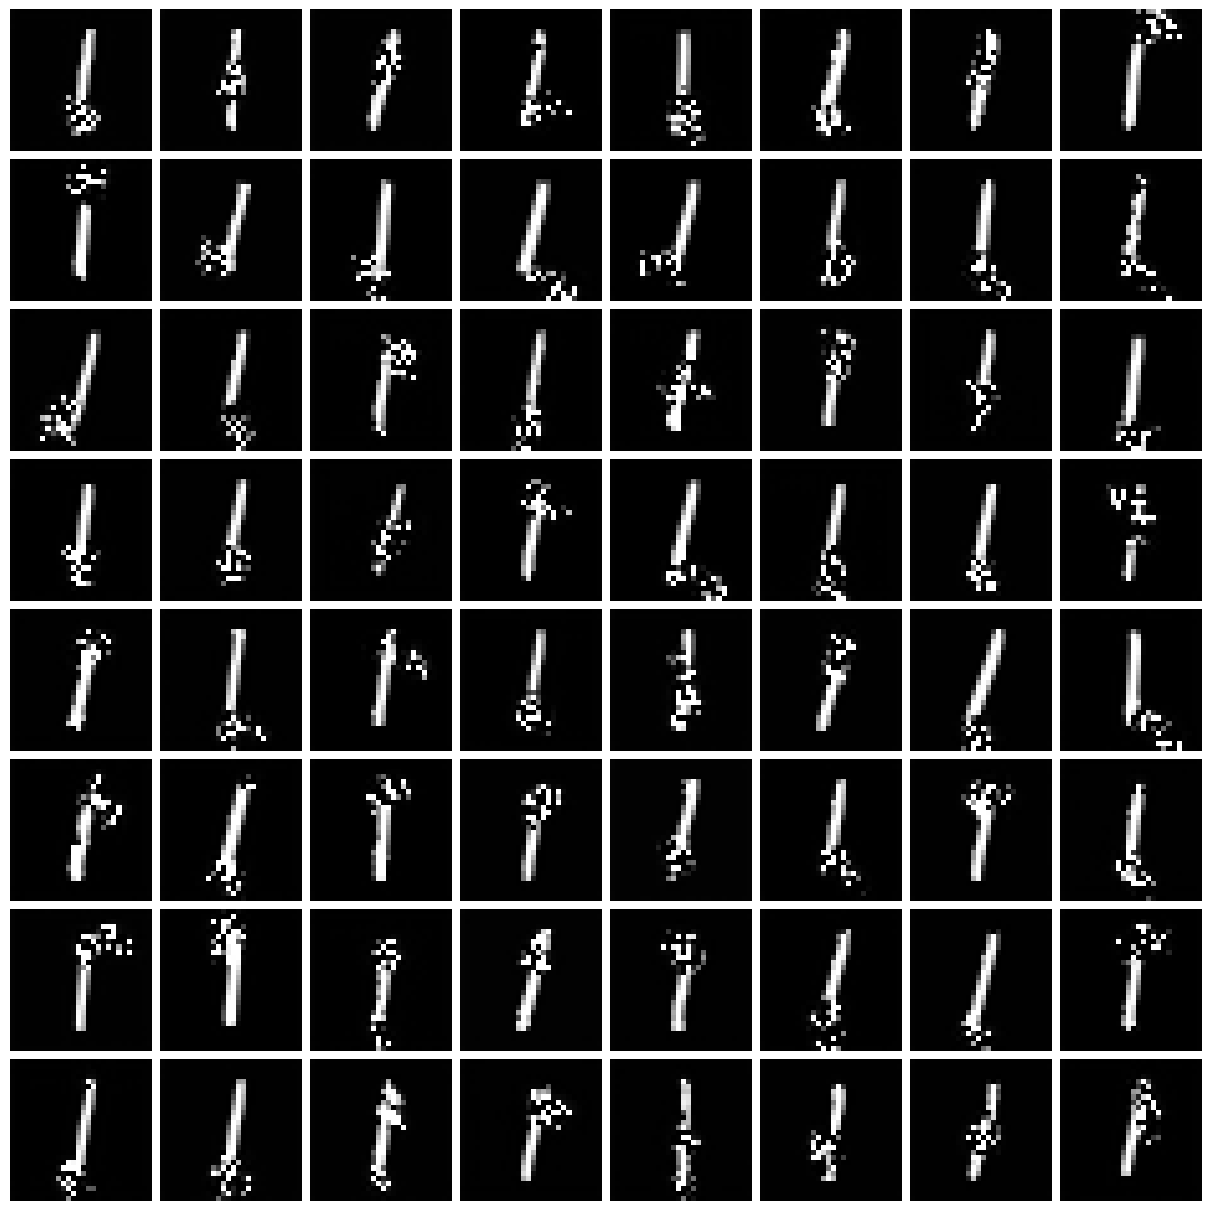

In [18]:
generated_images = gaussian_diffusion.sample(model1, model2, 28, batch_size=64, channels=1)

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [19]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
imgs = gaussian_diffusion.sample(model1, model2, 28, batch_size=1000, channels=1)
images_from_ddpm = (255*(1 + imgs[-1].copy())/2) 
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_ddpm, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step
FID (1000 images) : 188.4683380126953


In [20]:
torch.save(model1, 'models/OptCovSN_model1.pt')
torch.save(model2, 'models/OptCovSN_model2.pt')

## NPR Prediction

In [12]:
# Residual block
class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout, use_scale_shift_norm=False):
        super().__init__()
        self.use_scale_shift_norm = use_scale_shift_norm
        
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, 2 * out_channels if use_scale_shift_norm else out_channels)
        )
        
        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()
    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        emb_out = self.time_emb(t)[:, :, None, None]
        if self.use_scale_shift_norm:
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = self.conv2[0](h) * (1 + scale) + shift # GroupNorm(h)(w+1) + b
            h = self.conv2[1:](h)
        else:
            h = self.conv2(h + emb_out)
        return h + self.shortcut(x)

In [13]:
# The full UNet model with attention and timestep embedding
class UNetModel(nn.Module):
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4,
        use_scale_shift_norm=True,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        
        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        
        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout,
                        use_scale_shift_norm=use_scale_shift_norm)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2
        
        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm)
        )
        
        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout,
                        use_scale_shift_norm=use_scale_shift_norm
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )
    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        
        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)

In [14]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas
            
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        self.betas_cumprod = 1 - self.alphas_cumprod
        self.betas_cumprod_prev = 1 - self.alphas_cumprod_prev
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        #self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )
    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance
    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model1, model2, x_t, t, clip_denoised=True):
        # predict noise using model1, noise**2 using model2
        image_size = x_t.shape[-1]
        pred_noise = model1(x_t, t)
        pred_noise_error = model2(x_t, t)
        alp = self._extract(self.alphas_cumprod, t, x_t.shape)
        bet = self._extract(self.betas_cumprod, t, x_t.shape)
        bet_prev = self._extract(self.betas_cumprod_prev, t, x_t.shape)
        alp_prev = self._extract(self.alphas_cumprod_prev, t, x_t.shape)
        lambda_n_squared = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        gamma_n = torch.sqrt(alp_prev) - torch.sqrt((bet_prev - lambda_n_squared)*alp/bet)
        model_variance = (lambda_n_squared)*torch.ones(image_size,image_size).to(t.device) + (gamma_n**2) * bet/alp * (pred_noise_error)
        model_variance = F.relu(model_variance) # handling negative variances
        model_log_variance = torch.log(model_variance+1e-6)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, _, _ = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, model_variance, model_log_variance
        
    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model1, model2, x_t, t, clip_denoised=True):
        # predict mean and variance
        model_mean, model_variance, model_log_variance = self.p_mean_variance(model1, model2, x_t, t,
                                                    clip_denoised=clip_denoised)
        # print(t[0], model_variance.isnan().any())
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * torch.sqrt(model_variance)*noise # (0.5 * model_log_variance).exp() * noise
        return pred_img
    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model1, model2, shape):
        batch_size = shape[0]
        device = next(model1.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model1, model2, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs
    
    # sample new images
    @torch.no_grad()
    def sample(self, model1, model2, image_size, batch_size=8, channels=3):
        return self.p_sample_loop(model1, model2, shape=(batch_size, channels, image_size, image_size))

    def train_losses(self, model1, model2, x_start, t):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model1(x_noisy, t)
        predicted_noise_squared = model2(x_noisy, t)
        loss1 = F.mse_loss(noise, predicted_noise)
        loss2 = F.mse_loss((noise - predicted_noise)**2, predicted_noise_squared)
        return loss1, loss2
    

In [15]:
batch_size = 128
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model1 = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
    use_scale_shift_norm=False,
)
model1.to(device)

model2 = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
    use_scale_shift_norm=False,
)
model2.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps, beta_schedule='cosine')
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-4)

device='cuda:1'


In [16]:
# train
epochs = 5

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss1, loss2 = gaussian_diffusion.train_losses(model1, model2, images, t)
        loss = loss1 + loss2
        
        if step % 100 == 0:
            tqdm.write(f"Epoch {epoch+1} Step {step} Loss1: {loss1.item()} Loss2: {loss2.item()} Loss1: {loss.item()}")
        
        optimizer1.zero_grad() 
        optimizer2.zero_grad() 
        loss.backward()
        optimizer1.step()
        optimizer2.step()

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 Step 0 Loss1: 1.1551332473754883 Loss2: 3.53088116645813 Loss1: 4.686014175415039
Epoch 1 Step 100 Loss1: 0.11970295757055283 Loss2: 0.10488046705722809 Loss1: 0.22458341717720032
Epoch 1 Step 200 Loss1: 0.0952053815126419 Loss2: 0.08285605907440186 Loss1: 0.17806144058704376
Epoch 1 Step 300 Loss1: 0.07176753133535385 Loss2: 0.06756767630577087 Loss1: 0.13933521509170532
Epoch 1 Step 400 Loss1: 0.07938269525766373 Loss2: 0.07565972954034805 Loss1: 0.15504242479801178


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 Step 0 Loss1: 0.07048358768224716 Loss2: 0.07103382796049118 Loss1: 0.14151741564273834
Epoch 2 Step 100 Loss1: 0.052575960755348206 Loss2: 0.039341408759355545 Loss1: 0.09191736578941345
Epoch 2 Step 200 Loss1: 0.06309626996517181 Loss2: 0.05729270353913307 Loss1: 0.12038896977901459
Epoch 2 Step 300 Loss1: 0.05201782286167145 Loss2: 0.04517673701047897 Loss1: 0.09719455987215042
Epoch 2 Step 400 Loss1: 0.04681011661887169 Loss2: 0.036234091967344284 Loss1: 0.08304420858621597


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 Step 0 Loss1: 0.06716211140155792 Loss2: 0.06536589562892914 Loss1: 0.13252800703048706
Epoch 3 Step 100 Loss1: 0.056642744690179825 Loss2: 0.05292323976755142 Loss1: 0.10956598818302155
Epoch 3 Step 200 Loss1: 0.053663164377212524 Loss2: 0.04826636239886284 Loss1: 0.10192953050136566
Epoch 3 Step 300 Loss1: 0.05059326812624931 Loss2: 0.04639806970953941 Loss1: 0.09699133783578873
Epoch 3 Step 400 Loss1: 0.05965423956513405 Loss2: 0.06689468771219254 Loss1: 0.12654893100261688


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 Step 0 Loss1: 0.04970255494117737 Loss2: 0.04788251593708992 Loss1: 0.09758506715297699
Epoch 4 Step 100 Loss1: 0.048321135342121124 Loss2: 0.0407961830496788 Loss1: 0.08911731839179993
Epoch 4 Step 200 Loss1: 0.04424380138516426 Loss2: 0.03966176509857178 Loss1: 0.08390556275844574
Epoch 4 Step 300 Loss1: 0.05261464789509773 Loss2: 0.051624368876218796 Loss1: 0.10423901677131653
Epoch 4 Step 400 Loss1: 0.04483504220843315 Loss2: 0.03576095774769783 Loss1: 0.08059599995613098


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 Step 0 Loss1: 0.04679494723677635 Loss2: 0.04075038060545921 Loss1: 0.08754532784223557
Epoch 5 Step 100 Loss1: 0.03994019702076912 Loss2: 0.0322209894657135 Loss1: 0.07216118276119232
Epoch 5 Step 200 Loss1: 0.04987071454524994 Loss2: 0.045137397944927216 Loss1: 0.09500811249017715
Epoch 5 Step 300 Loss1: 0.05239344388246536 Loss2: 0.053551506251096725 Loss1: 0.10594494640827179
Epoch 5 Step 400 Loss1: 0.04516991600394249 Loss2: 0.04224850982427597 Loss1: 0.08741842210292816


sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

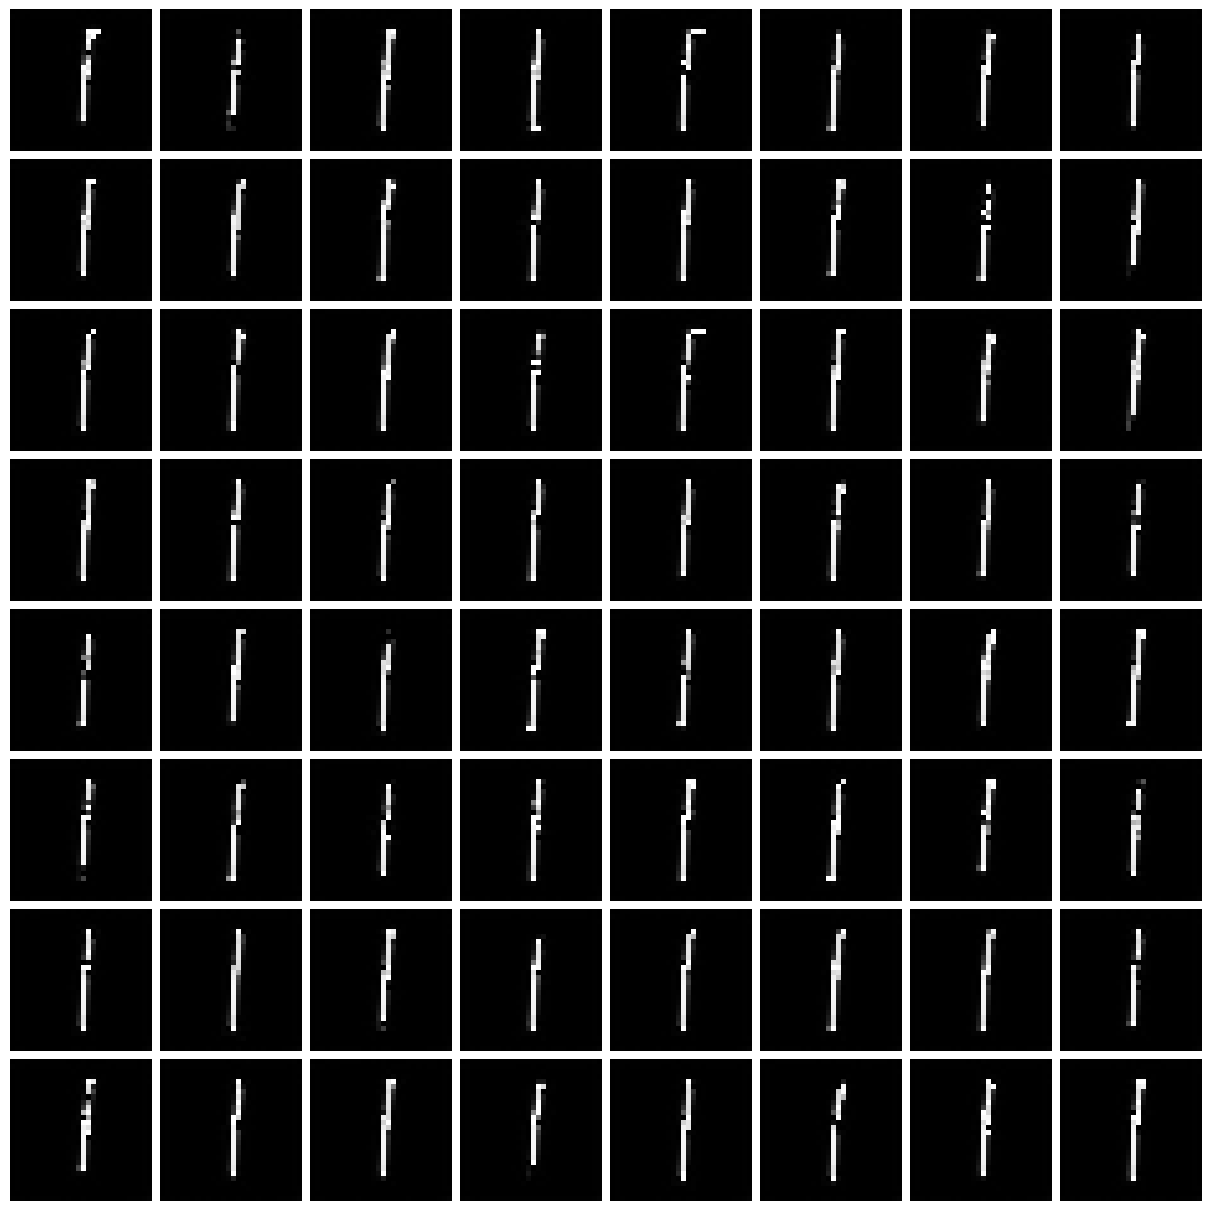

In [17]:
generated_images = gaussian_diffusion.sample(model1, model2, 28, batch_size=64, channels=1)

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [18]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
imgs = gaussian_diffusion.sample(model1, model2, 28, batch_size=1000, channels=1)
images_from_ddpm = (255*(1 + imgs[-1].copy())/2) 
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_ddpm, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step
FID (1000 images) : 291.05596923828125


In [19]:
torch.save(model1, 'models/OptCovNPR_model1.pt')
torch.save(model2, 'models/OptCovNPR_model2.pt')

In [20]:
sum([p.numel() for p in model1.parameters()])

13796545

## Making the variance schedule learnable

In [12]:
class VarModel(nn.Module) :
    def __init__(self, timesteps) :
        super().__init__()
        self.timesteps = timesteps
        self.lin = nn.Sequential(
            nn.Linear(1, self.timesteps),
            nn.Sigmoid()
        )
    def forward(self, t) :
        return self.lin((t/timesteps).float())

In [13]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
    ):
        self.timesteps = timesteps
            
    def update_schedules(self, model, t) :
        self.betas = model(t.view(-1,1)) # (b,timesteps)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.clamp(torch.cumprod(self.alphas, axis=-1)*0.99, min=1e-4) # no element should be one
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:,:-1], (1, 0), value=1.)
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )

        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[:,1:2], self.posterior_variance[:,1:]], dim=-1)
        )
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )
    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        # out = a.to(t.device).gather(0, t).float()
        out = a[:,t[0]].float() # fix using gather later
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance
    
    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        # print(self.posterior_mean_coef1.isnan().any().item(), self.posterior_mean_coef2.isnan().any().item(), x_start.isnan().any().item(), x_t.isnan().any().item())
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        temp = (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - 
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
        return temp 
    
    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # predict noise using model
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance
    
    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t,
                                                    clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img
    
    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, varModel, shape):
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            t = torch.full((batch_size,), i, device=device, dtype=torch.long)
            self.update_schedules(varModel, t)
            img = self.p_sample(model, img, t)
            imgs.append(img.cpu().numpy())
        return imgs
    
    # sample new images
    @torch.no_grad()
    def sample(self, model, varModel, image_size, batch_size=8, channels=3):
        return self.p_sample_loop(model, varModel, shape=(batch_size, channels, image_size, image_size))
    
    # use ddim to sample
    @torch.no_grad()
    def ddim_sample(
        self,
        model,
        image_size,
        batch_size=8,
        channels=3,
        ddim_timesteps=50,
        ddim_discr_method="uniform",
        ddim_eta=0.0,
        clip_denoised=True):
        # make ddim timestep sequence
        if ddim_discr_method == 'uniform':
            c = self.timesteps // ddim_timesteps
            ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
        elif ddim_discr_method == 'quad':
            ddim_timestep_seq = (
                (np.linspace(0, np.sqrt(self.timesteps * .8), ddim_timesteps)) ** 2
            ).astype(int)
        else:
            raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')
        # add one to get the final alpha values right (the ones from first scale to data during sampling)
        ddim_timestep_seq = ddim_timestep_seq + 1
        # previous sequence
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])
        
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
            t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)
            
            # 1. get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod, prev_t, sample_img.shape)
    
            # 2. predict noise using model
            pred_noise = model(sample_img, t)
            
            # 3. get the predicted x_0
            pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
            if clip_denoised:
                pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)
            
            # 4. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            sigmas_t = ddim_eta * torch.sqrt(
                (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))
            
            # 5. compute "direction pointing to x_t" of formula (12)
            pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise
            
            # 6. compute x_{t-1} of formula (12)
            x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

            sample_img = x_prev
            
        return sample_img.cpu().numpy()
    
    # compute train losses
    def train_losses(self, model, varModel, x_start, t):
        # update var schedule
        self.update_schedules(varModel, t)
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

In [14]:
batch_size = 256
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f'{device=}')
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

varModel = VarModel(timesteps)
varModel.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
varOptimizer = torch.optim.Adam(varModel.parameters(), lr=5e-4)

device='cuda:0'


In [15]:
# train
epochs = 5
losslog = []

for epoch in range(epochs):
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, varModel, images, t)
        with torch.no_grad() : losslog.append(loss.item())
        
        if step % 400 == 0:
            tqdm.write(f"Loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 1.2031196355819702


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.0029682223685085773


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.0026640112046152353


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.0008348783012479544


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 0.0013393571134656668


sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

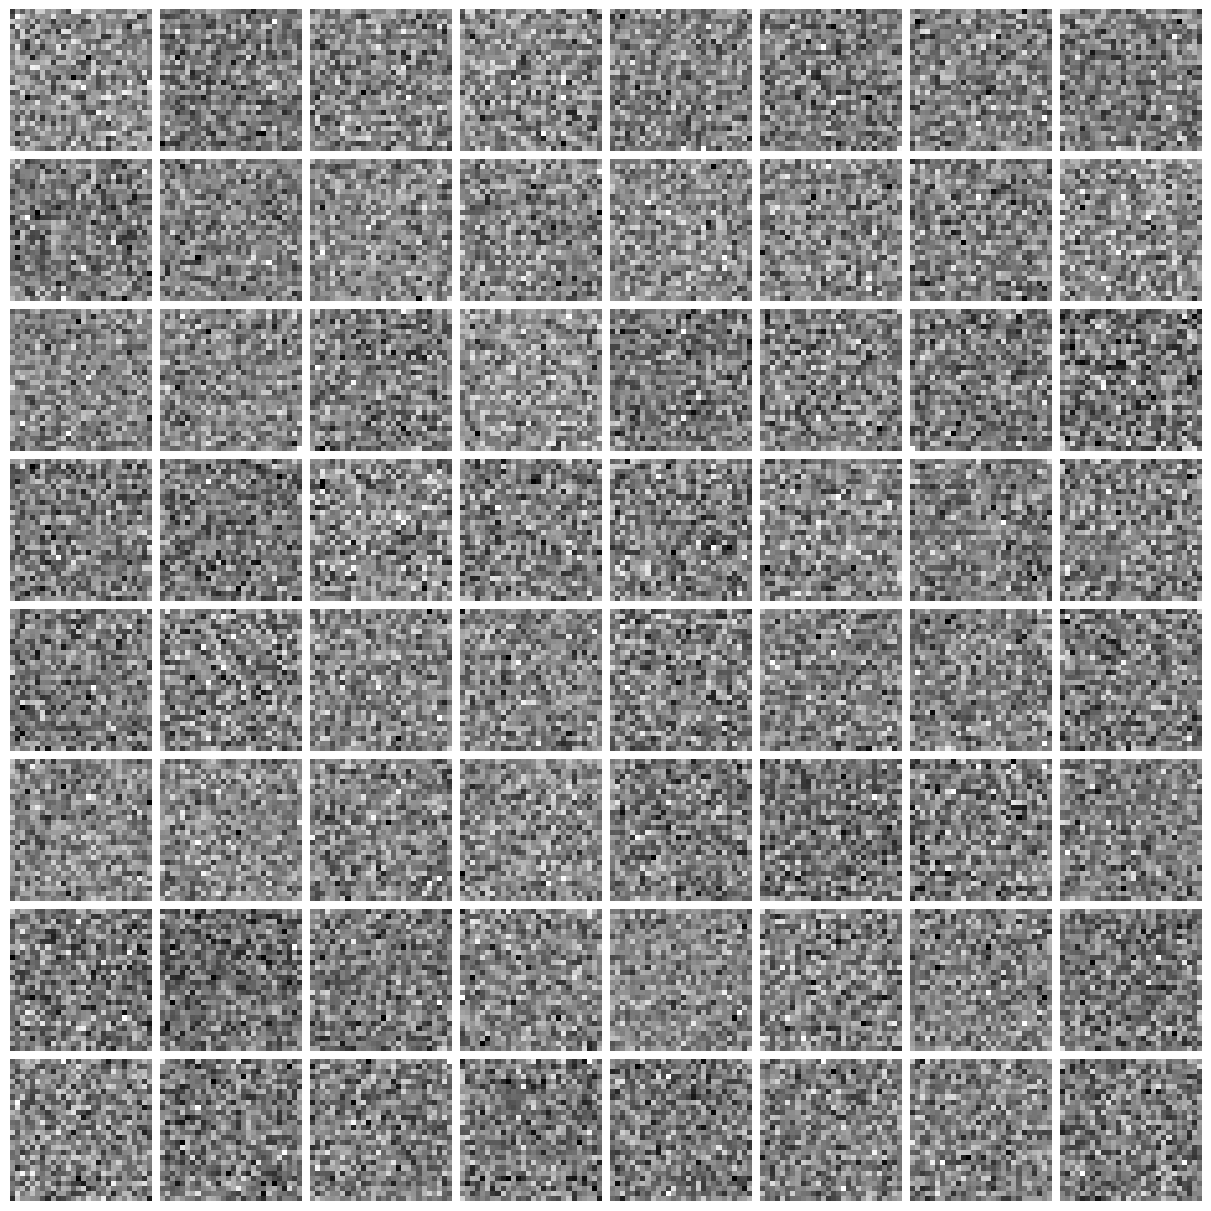

In [16]:
model.eval()
varModel.eval()
with torch.no_grad() :
    generated_images = gaussian_diffusion.sample(model, varModel, 28, batch_size=64, channels=1)

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [18]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
imgs = gaussian_diffusion.sample(model, varModel, 28, batch_size=1000, channels=1)
images_from_ddpm = (255*(1 + imgs[-1].copy())/2) 
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_ddpm, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step
FID (1000 images) : 346.9573059082031


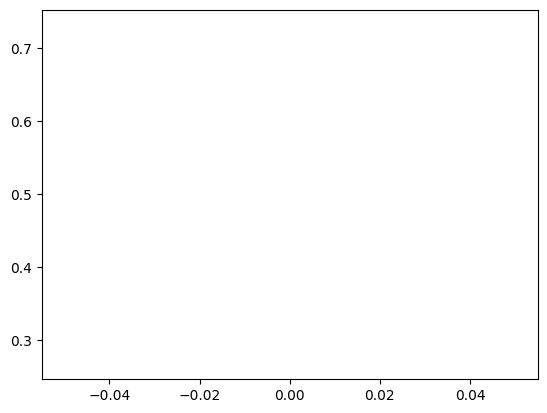

In [25]:
t = torch.tensor([1]).reshape(-1,1).to(device)
with torch.no_grad() :
    op = varModel(t)
plt.plot(op.cpu());

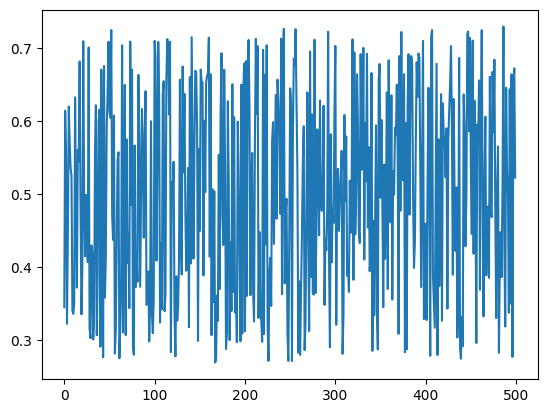

In [29]:
plt.plot(op.cpu()[0])